頑張って！<br>
<img src="images1/frieren.JPG" alt="frieren" width="100" height="100" style="float:left;border: 1px solid black">

### sobel initialization + 2 steps pbest/gbest search
（1）采用了sobel采样的准随机数生成种群 <br/>
（2）并且探索方式变为2阶段：<br/>
变量控制：普通ABC探索 / 单一蜜源历史最佳和种群最佳方向探索。

In [44]:
# Author: Bian Hanzhang

"""import packages"""
import random as rand
from copy import deepcopy
# import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import MultipleLocator
from scipy.stats import qmc

In [2]:
# read file
FILE_NAME = "/Users/bianhanzhang/Desktop/Coding/MY-ABC/data/asset pool/SP500_100_assets_pool2.csv"
data = pd.read_csv(FILE_NAME)
data.head(3)

,mean_return,MO,BLL,NTAP,AFL,AAP,SRE,MGM,DHI,AON,...,LH,INCY,ALB,TROW,PFE,HP,BEN,EA,NSC,ECL
0,0.001138,0.000102,0.000058,0.000071,0.000040,0.000037,0.000035,0.000049,0.000049,0.000062,...,0.000053,0.000039,0.000043,0.000026,0.000030,0.000052,0.000043,0.000075,0.000048,0.000031
1,-0.000027,0.000058,0.000216,0.000172,0.000069,0.000120,0.000053,0.000093,0.000088,0.000180,...,0.000102,0.000101,0.000072,0.000066,0.000041,0.000124,0.000082,0.000197,0.000118,0.000051
2,0.000937,0.000071,0.000172,0.000312,0.000080,0.000142,0.000044,0.000112,0.000101,0.000198,...,0.000120,0.000113,0.000081,0.000076,0.000011,0.000124,0.000098,0.000230,0.000114,0.000032


In [21]:
# mean return of 100 selected bonds
SP_mean_rtn = np.reshape(np.array(data.iloc[:, 0]), (100, 1))

# covariance of 100 selected bonds
SP_cov_rtn = np.array(data.iloc[:, 1:])

In [22]:
class ParameterInformation:
    """
    Store algorithm's parameters:
    - population: amount of bees = employed bees = onlooking bees
    - dimension: number of genes in a chromosome
    - max_bound: upper bound of one gene on chromosome
    - min_bound: lower bound of one gene on chromosome
    - max_iter_num: max iteration times of each nectar
    - algo_iter_num: current iteration times of the algorithm 
    - algo_max_iter_num: max iteration times of the algorithm
    - risk_averse_para: risk aversion parameter of investor
    - cardinality: number of assets included in the portfolio
    - SPP: scout production cycle
    """

    def __init__(self, population, dimension, min_bound, max_bound, max_iter_num,
                 algo_max_iter_num, risk_averse_para, cardinality, SPP):
        self.population = population
        self.dimension = dimension
        self.max_bound = max_bound
        self.min_bound = min_bound
        self.max_iter_num = max_iter_num
        self.algo_iter_num = 0  # Initialize to 0 as the algorithm hasn't started
        self.algo_max_iter_num = algo_max_iter_num
        self.risk_averse_para = risk_averse_para
        self.cardinality = cardinality
        self.SPP = SPP

    def set_algo_iter_num(self, value):
        """Set algorithm's iteration number"""
        self.algo_iter_num = value

    def show_parameter(self):
        """Show parameter"""
        print("Parameter Information:")
        print(f"Population: {self.population}")
        print(f"Dimension: {self.dimension}")
        print(f"Bounds: [{self.min_bound}, {self.max_bound}]")
        print(f"Cardinality: {self.cardinality}")
        print(f"Max Iter Num: {self.max_iter_num}")
        print(f"Algo Max Iter Num: {self.algo_max_iter_num}")
        print(f"Risk Averse Parameter: {self.risk_averse_para}")

***
### log_Nectar
1.random_直接用随机生成0，1是否更快 <br>
2.已将class级的变量删除 <br>
3.染色体初始化为0 array <br>
4.限定了dv为int <br>

In [23]:
class Nectar:
    """nectar(chromosome) information"""

    def __init__(self, dimension) -> None:
        """initialize chromosome and decision variable"""
        self.chromosome = np.zeros(dimension)
        self.dv = np.zeros(dimension, dtype=int)
        self.fitness = 0
        self.test_func_value = 0
        self.iter_num = 0
        self.select_probability = 0
        self.best_chromosome = np.zeros(dimension)
        self.best_dv = np.zeros(dimension, dtype=int)
        self.best_test_value = 999

    def set_chromosome(self, i, value):
        """set one position of the chromosome"""
        self.chromosome[i] = value

    def set_chromosome_all(self, new_chromosome):
        self.chromosome = new_chromosome

    def random_chromosome(self, min_bound, max_bound, dimension):
        """randomly generate a chromosome"""
        self.chromosome = np.random.uniform(min_bound, max_bound, dimension)

    def set_dv(self, i, value):
        """set one position of decision variable"""
        self.dv[i] = value

    def random_dv(self, dimension):
        """randomly generate the decision variable"""
        rnd = np.random.uniform(0, 1, dimension)
        self.dv = np.where(rnd < 0.5, 0, 1)

    def set_fitness(self, value):
        """set fitness of the nectar"""
        self.fitness = value

    def set_test_func_value(self, value):
        """set value of test function"""
        self.test_func_value = value

    def set_iter_num(self, value):
        """set number of times this nectar has been explored"""
        self.iter_num = value

    def set_select_probability(self, value):
        """set probability calculated by roulette"""
        self.select_probability = value

    def save_best(self):
        if self.test_func_value < self.best_test_value:
            self.best_chromosome = deepcopy(self.chromosome)
            self.best_dv = deepcopy(self.dv)

### CCMV model 
s.t.<br>
(1) weight constraint <br>
(2) cardinality constraint <br>
(3) quantity constraint <br>
(4) 0-1 constraint <br>
<img src="images1/CCMV_model.png" alt="explanation of CCMV" style="float:left; height:200px; width:auto; border:1px solid black">

In [45]:
# fix:修正目标函数计算中的x为dv=1对应的资产，并且进行了归一化

# modeling
def mean_variance(x, dv, mean_rtn, cov_rtn, risk_averse_para) -> float:
    """calculate objective function value"""

    # if decision variable is 0, set x = 0
    x[dv == 0] = 0

    # normalization
    total_weight = np.sum(x)
    if total_weight == 0:
        raise ValueError("Sum of weight is zero!")
    x = x/total_weight

    # objective function
    portfolio_variance = np.dot(np.dot(x.T, cov_rtn), x)
    portfolio_return = np.dot(x.T, mean_rtn)
    obj_func = risk_averse_para * portfolio_variance - \
        (1 - risk_averse_para) * portfolio_return

    return obj_func


def cal_fitness(obj_value) -> float:
    """calculate fitness value by obj_value"""
    if obj_value >= 0:
        fitness = 1 / (1 + obj_value)
    else:
        fitness = 1 + abs(obj_value)
    return fitness

# /need fix/ fixed
# 制约违反修改为Cardinality制约的违反程度


def cal_violation(chromosome, dv, parameter):
    """calculate violation of solution vector"""
    weights = chromosome[np.where(dv == 1)]
    violation = np.where(weights > parameter.max_bound, weights - parameter.max_bound, 0) + \
        np.where(weights < parameter.min_bound,
                 parameter.min_bound - weights, 0)
    total_violation = np.sum(violation)

    return total_violation

# need fix / fixed


def deb_method(parameter, nectar, neighbor) -> bool:
    """ whether nectar will be replaced by neighbor """

    vio_nectar = cal_violation(nectar.chromosome, nectar.dv, parameter)
    vio_neighbor = cal_violation(neighbor.chromosome, neighbor.dv, parameter)
    if vio_nectar > 0 and vio_neighbor > 0:
        return vio_nectar > vio_neighbor
    elif vio_nectar > 0 and vio_neighbor == 0:
        return True
    elif vio_nectar == 0 and vio_neighbor > 0:
        return False
    else:
        return nectar.fitness < neighbor.fitness

#### c用来衡量资产的收益风险比率的系数，类似于sharp ratio 
<img src="images1/c-value.png" alt="explanation of c" style="float:left; height:200px; width:auto; border:1px solid black">

In [25]:
# calculate c value of all assets
def calculate_c(data, parameter):
    theta = np.array([1 + (1 - parameter.risk_averse_para)
                     * x for x in data.iloc[:, 0]])
    phi = np.array([1 + parameter.risk_averse_para * sum(data.iloc[i, 1:]) /
                   parameter.dimension for i in range(parameter.dimension)])
    omega = -1 * min(0, min(theta))
    psi = -1 * min(0, min(phi))
    c = np.array([(theta[i] + omega)/(phi[i] + psi)
                 for i in range(parameter.dimension)])
    return c

In [26]:
def highest_c(asset_selected, c):
    """select the highest c value asset that is not included in portfolio"""
    c[asset_selected] = -999
    max_val = np.max(c)
    asset_index = np.where(c == max_val)[0][0]
    return asset_index


def lowest_c(asset_selected, c):
    """选择投资组合中包含的最低 c 值资产。

    参数:
    asset_selected (list or ndarray): 投资组合中当前选中的资产索引。
    c (ndarray): 所有资产的 'c' 值数组。

    返回:
    int: 在选中资产中 'c' 值最低的资产索引。
    """
    # 提取选中资产的 'c' 值
    selected_c_values = c[asset_selected]

    # 在选中资产子集中找到最小 'c' 值的索引
    min_idx_local = np.argmin(selected_c_values)

    # 将子集中的局部索引转换为原始数组中的全局索引
    asset_index = asset_selected[min_idx_local]

    return asset_index

In [27]:
# function to randomly select a number that is different from/not in i(list or int)

def random_k(i, population):
    # 确保 i 为列表统一处理
    if isinstance(i, (int, np.integer)):
        excluded = {i}
    else:
        excluded = set(i)

    # 生成一个可能的选择列表，排除了 'excluded' 元素
    possible_choices = list(set(range(population)) - excluded)

    # 从剩余可能选择中随机选取
    return np.random.choice(possible_choices)

### Arrangement Function
两种思路：<br>
1.在每次跟随蜂迭代结束后，需要使用arrangement函数使得种群中每个解满足约束 <br>
2.arrangement函数改为修正单个蜜源的制约违反，用于探索后将不可行解变为可行解，再和原蜜源比较 ***多维情况下可能会降低多样性*** <br>
如采取思路2，计算目标函数值的时候可以不再进行normalization操作。<br>
(1)确保资产组合满足cardinality制约：移除多余，不足添加 ***已实现***<br>
(2)确保在资产组合中的资产权重和为1 ***已实现***<br> 
(3)确保每一种资产比例在最小值和最大值范围内 ***！未实现 是否需要存疑***

In [28]:
# arrangement function idea1
# 修正Cardinality制约
def arrangement1(nectar_sources, parameter, c):
    for nectar in nectar_sources:
        selected_index = np.where(nectar.dv == 1)[0].tolist()
        # print(f"selected index: {selected_index}")
        asset_num = sum(nectar.dv)
        diff = asset_num - parameter.cardinality
        # print(f"diff: {diff}")
        if diff > 0:
            # remove redundant assets
            cnt = 0
            while cnt < diff:
                random_num = np.random.uniform(0, 1)
                if random_num < 0.5:
                    # randomly select an selected asset and remove from the portfolio
                    # let dv[selected]=0
                    ast_selected = np.random.choice(selected_index)
                    selected_index.remove(ast_selected)
                    nectar.set_dv(ast_selected, 0)
                elif random_num >= 0.5:
                    # select the asset with lowest c-value
                    ast_selected = lowest_c(selected_index, c)
                    # print(f"type:{type(ast_selected)}")
                    selected_index.remove(ast_selected)
                    nectar.set_dv(ast_selected, 0)
                cnt += 1
        elif diff < 0:
            # add assets
            cnt = 0
            diff = abs(diff)
            while cnt < diff:
                random_num = np.random.uniform(0, 1)
                if random_num < 0.5:
                    # randomly select an unselected asset and put into the portfolio
                    # let dv[selected]=1
                    ast_selected = random_k(
                        selected_index, parameter.dimension)
                    selected_index.append(ast_selected)
                    nectar.set_dv(ast_selected, 1)
                elif random_num >= 0.5:
                    # select the asset with highest c-value
                    ast_selected = highest_c(selected_index, c)
                    selected_index.append(ast_selected)
                    nectar.set_dv(ast_selected, 1)
                cnt += 1

        # Normalization for dv == 1
        weights = nectar.chromosome[nectar.dv == 1]
        sum_of_weights = np.sum(weights)
        weights = weights / sum_of_weights
        nectar.chromosome[nectar.dv == 1] = weights

    return nectar_sources

In [29]:
# arrangement function ider2

def arrangement2(nectar, parameter, c):
    selected_index = np.where(nectar.dv == 1)[0].tolist()
    # print(f"selected index: {selected_index}")
    asset_num = sum(nectar.dv)
    diff = asset_num - parameter.cardinality
    # print(f"diff: {diff}")
    if diff > 0:
        # remove redundant assets
        cnt = 0
        while cnt < diff:
            random_num = np.random.uniform(0, 1)
            if random_num < 0.5:
                # randomly select an selected asset and remove from the portfolio
                # let dv[selected]=0
                ast_selected = np.random.choice(selected_index)
                selected_index.remove(ast_selected)
                nectar.set_dv(ast_selected, 0)
            elif random_num >= 0.5:
                # select the asset with lowest c-value
                ast_selected = lowest_c(selected_index, c)
                # print(f"type:{type(ast_selected)}")
                selected_index.remove(ast_selected)
                nectar.set_dv(ast_selected, 0)
            cnt += 1
    elif diff < 0:
        # add assets
        cnt = 0
        diff = abs(diff)
        while cnt < diff:
            random_num = np.random.uniform(0, 1)
            if random_num < 0.5:
                # randomly select an unselected asset and put into the portfolio
                # let dv[selected]=1
                ast_selected = random_k(selected_index, parameter.dimension)
                selected_index.append(ast_selected)
                nectar.set_dv(ast_selected, 1)
            elif random_num >= 0.5:
                # select the asset with highest c-value
                ast_selected = highest_c(selected_index, c)
                selected_index.append(ast_selected)
                nectar.set_dv(ast_selected, 1)
            cnt += 1

    # Normalization for dv == 1
    weights = nectar.chromosome[nectar.dv == 1]
    sum_of_weights = np.sum(weights)
    weights = weights / sum_of_weights
    nectar.chromosome[nectar.dv == 1] = weights

    return nectar

### log_Initialization of nectar sources 
(1)是否在初始化时进行arrangement <br>
(2)copy是否需要复制该蜜源的迭代次数和被选择概率、能否直接用深拷贝？ <br>
(3)在保存全局最优蜜源时，比较的是目标函数值还是适应度？

In [30]:
def sobol_sequence(dimension, lb, ub):
    sobol = qmc.Sobol(d=1)
    # 生成长度为100的样本
    sample = sobol.random_base2(m=7)  # 生成2^7 = 128个样本，然后取前100个
    sample = sample[:dimension]

    # 将样本缩放到[0.001, 0.4]范围
    lower_bound = lb
    upper_bound = ub
    scaled_sample = qmc.scale(sample, lower_bound, upper_bound)

    # 将结果转换为ndarray
    result_array = np.array(scaled_sample).flatten()

    return result_array

In [31]:
def init_nectar_sources(nectar_sources, best_nectar_source, parameter, mean_rtn, cov_rtn, c):
    """initialize the nectar sources"""
    best_nectar_source.random_dv(parameter.dimension)
    best_nectar_source.set_chromosome_all(sobol_sequence(
        parameter.dimension, parameter.min_bound, parameter.max_bound))

    best_nectar_source.set_test_func_value(mean_variance(
        best_nectar_source.chromosome, best_nectar_source.dv,
        mean_rtn, cov_rtn, parameter.risk_averse_para))

    best_nectar_source.set_fitness(
        cal_fitness(best_nectar_source.test_func_value))

    # best_nectar_source.set_select_probability(0)
    # best_nectar_source.set_iter_num(0)

    for i in range(parameter.population):
        nectar_sources[i].set_chromosome_all(
            sobol_sequence(parameter.dimension, parameter.min_bound, parameter.max_bound))
        nectar_sources[i].random_dv(parameter.dimension)

    for i in range(parameter.population):
        nectar_sources[i].set_test_func_value(mean_variance(
            nectar_sources[i].chromosome, nectar_sources[i].dv, mean_rtn,
            cov_rtn, parameter.risk_averse_para))

        nectar_sources[i].set_fitness(
            cal_fitness(nectar_sources[i].test_func_value))
        # nectar_sources[i].set_select_probability(0)
        # nectar_sources[i].set_iter_num(0)


def regenerate_nectar(nectar_sources, i, parameter, mean_rtn, cov_rtn):
    """regenerate the i-th nectar"""
    nectar_sources[i].set_chromosome_all(
        sobol_sequence(parameter.dimension, parameter.min_bound, parameter.max_bound))
    nectar_sources[i].random_dv(parameter.dimension)
    nectar_sources[i].set_test_func_value(
        mean_variance(nectar_sources[i].chromosome, nectar_sources[i].dv,
                      mean_rtn, cov_rtn, parameter.risk_averse_para))
    nectar_sources[i].set_fitness(
        cal_fitness(nectar_sources[i].test_func_value))
    nectar_sources[i].set_select_probability(0)
    nectar_sources[i].set_iter_num(0)

#####
# 比较目标函数值还是适应度？


def save_best_nectar_source(nectar_sources, best_nectar_source, parameter):
    """save the best nectar source into best_nectar_source"""
    sum_func = 0
    for i in range(parameter.population):
        sum_func += nectar_sources[i].test_func_value
        if nectar_sources[i].test_func_value < best_nectar_source.test_func_value:
            best_nectar_source = deepcopy(nectar_sources[i])
            # print("yes")
    # print(sum_func)
    return best_nectar_source

In [83]:
def random_flip(array, flip_probability=0.1):
    """
    对于一个0和1组成的数组，每个元素都有给定概率进行反转。
    
    参数:
    array (np.ndarray): 输入的0和1组成的数组
    flip_probability (float): 每个元素反转的概率，默认为0.1
    
    返回:
    np.ndarray: 经过反转处理后的数组
    """
    # 生成与输入数组大小相同的随机数数组
    random_numbers = np.random.rand(array.size)
    
    # 根据反转概率创建一个布尔掩码
    flip_mask = random_numbers < flip_probability
    
    # 使用布尔掩码反转数组中的相应元素
    flipped_array = np.where(flip_mask, 1 - array, array)
    
    return flipped_array

In [106]:
def random_flip_single(bit, flip_probability=0.15):
    """
    对于一个0和1的数，有给定概率进行反转。
    
    参数:
    bit (int): 输入的0或1
    flip_probability (float): 反转的概率，默认为0.1
    
    返回:
    int: 经过反转处理后的数
    """
    if not (bit == 0 or bit == 1):
        raise ValueError("Input must be 0 or 1")

    # 生成一个随机数
    random_number = np.random.rand()
    
    # 根据反转概率决定是否反转
    if random_number < flip_probability:
        bit = 1 - bit  # 反转0变为1，1变为0
    
    return bit

### 雇佣峰行为
逻辑：用neighbor暂时储存探索值，再用deb's method比较后选择 <br>
改进点：探索方法可以考虑***当前最佳蜜源***的影响 <br>

目前的探索方法：<br>
<img src="images1/explore_method.png" alt="exploration method" style="float:left; height:200px; width:auto; border:1px solid black">

In [156]:
np.random.rand(1)

array([0.98172282])

In [168]:
# /need fix/
# neighbor直接深拷贝蜜源i
# dv的探索方法，和染色体基因的联系 fixed
# 是否z的更新也要看是否超过了MR fixed

def employed_bee_behavior(nectar_sources, best_nectar_source, parameter, mean_rtn, cov_rtn, c, MR, expo_way):
    """employed bee behavior"""
    for i in range(parameter.population):

        # deepcopy neighbor from the i-th nectar_source
        neighbor = deepcopy(nectar_sources[i])

        # explore every positon of the dv and chromosome if random > MR
        for j in range(parameter.dimension):
            if np.random.rand() < MR:

                # randomly select another nectar k to crossover, k!=i
                k = random_k(i, parameter.population)

                # update dv[j]
                
                if expo_way == 0:
                    expo = -nectar_sources[i].dv[j] + rand.uniform(-1,1) * \
                    (nectar_sources[i].dv[j] - nectar_sources[k].dv[j])
                    zij = round(1/(1 + np.exp(expo)) - 0.06)
                    neighbor.set_dv(j, zij)
                elif expo_way == 1:
                    expo = -nectar_sources[i].dv[j]  + \
                        rand.uniform(0, 1) * (nectar_sources[i].best_dv[j] - nectar_sources[i].dv[j]) + \
                        rand.uniform(0, 1) * (best_nectar_source.dv[j] - nectar_sources[i].dv[j])
                    zij = round(1/(1 + np.exp(expo)) - 0.06)
                    neighbor.set_dv(j, zij)
                else:
                    zij = 1 if np.random.rand(1)>=0.9 else 0
                    # zij = random_flip_single(nectar_sources[i].dv[j])
                    neighbor.set_dv(j,zij)

                if zij == 1:
                    # k = random_k(i,parameter.population)
                    
                    if expo_way == 0 or expo_way == 2:
                        update = nectar_sources[i].chromosome[j] + rand.uniform(-1, 1) * \
                            (nectar_sources[i].chromosome[j] - nectar_sources[k].chromosome[j])
                    elif expo_way == 1:
                        update = nectar_sources[i].chromosome[j] + \
                            rand.uniform(0, 1) * (nectar_sources[i].best_chromosome[j] - nectar_sources[i].chromosome[j]) + \
                            rand.uniform(0, 1) * (best_nectar_source.chromosome[j] - nectar_sources[i].chromosome[j])

                    neighbor.set_chromosome(j, update)

                    # preventing from exceeding boundary
                    if neighbor.chromosome[j] > parameter.max_bound:
                        neighbor.chromosome[j] = parameter.max_bound
                    elif neighbor.chromosome[j] < parameter.min_bound:
                        neighbor.chromosome[j] = parameter.min_bound

        # arrange neighbor to satisfy constraints
        neighbor = arrangement2(neighbor, parameter, c)

        # calculate fitness of neighbor_chromosome and plus iter
        neighbor_test_func_value = mean_variance(
            neighbor.chromosome, neighbor.dv, mean_rtn, cov_rtn, parameter.risk_averse_para)
        neighbor_fitness = cal_fitness(neighbor_test_func_value)

        neighbor.set_test_func_value(neighbor_test_func_value)
        neighbor.set_fitness(neighbor_fitness)

        # deb's method
        # print(deb_method(parameter,nectar_sources[i],neighbor))
#         print(neighbor_fitness)
#         print(nectar_sources[i].fitness)
        if deb_method(parameter, nectar_sources[i], neighbor):

            nectar_sources[i] = neighbor
            nectar_sources[i].set_iter_num(0)
            nectar_sources[i].save_best()
            # 是否需要将蜜源i的迭代次数归0 已修改
        else:
            nectar_sources[i].set_iter_num(
                nectar_sources[i].iter_num + 1)

    # algorithms's iteration times +1
    parameter.set_algo_iter_num(parameter.algo_iter_num + 1)

### 轮盘赌选择跟随峰跟随的蜜源
思路：基于蜜源的制约违反程度violation和适应度生成被选择的概率列表 <br>
改动：即使为不可行解，也考虑了适应度的大小 <br>
if violation > 0: prob = (1 - v/sum(violation) + f/sum(fitness) * 0.5 which < 0.5 <br>
else: prob = 0.5 + f/sum(fitness) * 0.5  which > 0.5<br>

In [42]:
# /need fix/  fixed
# 即使为不可行解，也需要考虑适应度的大小
# 在v>0时，添加了f/sum(fitness)，但这一项的权重大小还需考虑
# 应该为返回一个概率列表

def roulette(nectar_sources, parameter) -> list:
    """calculate each nectar's selection probability"""

    fitness_list = np.array([nectar.fitness for nectar in nectar_sources])
    violation_list = np.array([cal_violation(nectar.chromosome, nectar.dv, parameter)
                              for nectar in nectar_sources]).reshape(parameter.population, 1)

    total_fitness = np.sum(fitness_list)
    total_violation = np.sum(violation_list)

    prob_list = np.zeros_like(fitness_list, dtype=float)

    violated = violation_list > 0

    prob_list[violated] = (1 - violation_list[violated] / total_violation) * 0.5

    prob_list[~violated] = 0.5 + fitness_list[~violated] / total_fitness * 0.5

    return prob_list

In [167]:
# /need fix/ fixed
# dv的更新
#####
def onlooking_bee_behavior(nectar_sources, best_nectar_source, parameter, mean_rtn, cov_rtn, c, MR, expo_way):
    """onlooking bee behavior"""
    i = 0
    prob_list = roulette(nectar_sources, parameter)
    nectar_list = np.arange(0, parameter.population)

    while i < parameter.population:

        # select a nectar based on probability(roulette)
        # add [0] : rand.choices returns a list -> turns list into int
        nectar_selected = rand.choices(nectar_list, prob_list)[0]

        # copy chromosome and dv from selected nectar_source
        neighbor = deepcopy(nectar_sources[nectar_selected])

        # expolore every position of the selected dv and chromosome
        for j in range(parameter.dimension):
            if np.random.rand() < MR:

                # randomly select another nectar k to crossover, k!=nectar_selected
                k = random_k(nectar_selected, parameter.population)

                if expo_way == 0:
                    expo = -nectar_sources[nectar_selected].dv[j] + rand.uniform(-1,1) * \
                    (nectar_sources[nectar_selected].dv[j] - nectar_sources[k].dv[j])
                    zij = round(1/(1 + np.exp(expo)) - 0.06)
                    neighbor.set_dv(j, zij)
                elif expo_way == 1:
                    expo = -nectar_sources[nectar_selected].dv[j]  + \
                        rand.uniform(0, 1) * (nectar_sources[nectar_selected].best_dv[j] - nectar_sources[nectar_selected].dv[j]) + \
                        rand.uniform(0, 1) * (best_nectar_source.dv[j] - nectar_sources[nectar_selected].dv[j])
                    zij = round(1/(1 + np.exp(expo)) - 0.06)
                    neighbor.set_dv(j, zij)
                else:
                    zij = 1 if np.random.rand(1) >= 0.9 else 0
                    #zij = random_flip_single(nectar_sources[nectar_selected].dv[j])
                    neighbor.set_dv(j,zij)

                if zij == 1:
                    # k = random_k(i,parameter.population)
                    
                    if expo_way == 0 or expo_way == 2:
                        update = nectar_sources[nectar_selected].chromosome[j] + rand.uniform(-1, 1) * \
                            (nectar_sources[nectar_selected].chromosome[j] - nectar_sources[k].chromosome[j])
                    elif expo_way == 1:
                        update = nectar_sources[i].chromosome[j] + \
                            rand.uniform(0, 1) * (nectar_sources[nectar_selected].best_chromosome[j] - nectar_sources[nectar_selected].chromosome[j]) + \
                            rand.uniform(0, 1) * (best_nectar_source.chromosome[j] - nectar_sources[nectar_selected].chromosome[j])


                    # preventing from exceeding boundary
                    if neighbor.chromosome[j] > parameter.max_bound:
                        neighbor.chromosome[j] = parameter.max_bound
                    elif neighbor.chromosome[j] < parameter.min_bound:
                        neighbor.chromosome[j] = parameter.min_bound

        # arrange neighbor to satisfy constraints
        neighbor = arrangement2(neighbor, parameter, c)

        # calculate fitness of neighbor_chromosome and plus iter
        neighbor_test_func_value = mean_variance(
            neighbor.chromosome, neighbor.dv, mean_rtn, cov_rtn, parameter.risk_averse_para)
        neighbor_fitness = cal_fitness(neighbor_test_func_value)

        neighbor.set_test_func_value(neighbor_test_func_value)
        neighbor.set_fitness(neighbor_fitness)

        # deb's method
        # print(deb_method(parameter,nectar_sources[nectar_selected],neighbor))
        if deb_method(parameter, nectar_sources[nectar_selected], neighbor):
            nectar_sources[nectar_selected] = neighbor
            nectar_sources[nectar_selected].set_iter_num(0)
            nectar_sources[i].save_best()
        else:
            nectar_sources[nectar_selected].set_iter_num(
                nectar_sources[nectar_selected].iter_num + 1)
        i += 1

### 侦查蜂行为
循环蜜源列表，如果有蜜源的迭代次数超过了最大迭代次数则重新生成该蜜源 <br>

In [35]:
# /need fix/
# SPP的运用/或者和遗传算法结合
#####
def scout_bee_behavior(nectar_sources, parameter, mean_rtn, cov_rtn):
    """scout bee behavior"""
    for i in range(parameter.population):
        if nectar_sources[i].iter_num > parameter.max_iter_num:
            regenerate_nectar(nectar_sources, i, parameter, mean_rtn, cov_rtn)

In [137]:
def get_expo_way(algo_iter_num, SPP, s1 , s2):
    ratio = (algo_iter_num % SPP) / SPP

    if 0 <= ratio < s1:
        expo_way = 0
    elif s1 <= ratio < s2:
        expo_way = 1
    elif s2 <= ratio <= 1:
        expo_way = 2
    else:
        raise ValueError("Ratio out of expected range")

    return expo_way

### 算法主程序

In [134]:
def artificial_bee_colony(parameter, mean_rtn, cov_rtn, MR,s1 ,s2):
    """main function: control algorithm's process"""
    parameter.show_parameter()
    result_by_iter = []
    expo_way = 0
    nectar_sources = np.array([Nectar(parameter.dimension)
                              for i in range(parameter.population)])
    best_nectar_source = Nectar(parameter.dimension)
    c = calculate_c(data, parameter)
    # run algorithm max_test_num times and calculate mean result

    parameter.set_algo_iter_num(0)
    init_nectar_sources(nectar_sources, best_nectar_source,
                        parameter, mean_rtn, cov_rtn, c)
    # arrangement(nectar_sources,parameter,c)
    best_nectar_source = save_best_nectar_source(
        nectar_sources, best_nectar_source, parameter)

    while parameter.algo_iter_num < parameter.algo_max_iter_num:
        expo_way = get_expo_way(parameter.algo_iter_num,parameter.SPP,s1,s2)
        employed_bee_behavior(nectar_sources, best_nectar_source,
                              parameter, mean_rtn, cov_rtn, c, MR,expo_way)
        onlooking_bee_behavior(
            nectar_sources, best_nectar_source, parameter, mean_rtn, cov_rtn, c, MR,expo_way)
        # nectar_sources = arrangement1(nectar_sources,parameter,c)
        best_nectar_source = save_best_nectar_source(
            nectar_sources, best_nectar_source, parameter)
        if parameter.algo_iter_num % parameter.SPP == 0:
            scout_bee_behavior(nectar_sources, parameter, mean_rtn, cov_rtn)

        result = best_nectar_source.test_func_value
        result_by_iter.append(result)

        # result_vector[0] = best_nectar_source.chromosome
        # print(f"Algorithm Process {parameter.algo_iter_num / parameter.algo_max_iter_num * 100:.1f}%")

    # print(result_by_iter)
    draw(result_by_iter, parameter.algo_max_iter_num)
    best_nectar_source = arrangement2(best_nectar_source, parameter, c)

    return best_nectar_source,result_by_iter

In [37]:
def draw(func_value, max_algo_iter_num):
    '''画出收敛图'''
    x = np.linspace(0, max_algo_iter_num, max_algo_iter_num)
    plt.figure(num=1, figsize=(8, 5))  # num表示的是编号，figsize表示的是图表的长宽
    # plt.yscale('log')  # 设置纵坐标的缩放
    x_major_locator = MultipleLocator(
        max_algo_iter_num/10)  # 把x轴的刻度间隔设置为100，并存在变量里
    ax = plt.gca()  # ax为两条坐标轴的实例
    ax.xaxis.set_major_locator(x_major_locator)  # 把x轴的主刻度设置为100的倍数

    l1, = plt.plot(x, func_value, color='black',  # 线条颜色
                   linewidth=1.5,  # 线条宽度
                   linestyle='-',  # 线条样式
                   label='algorithm1')
    plt.show()

In [38]:
def draw_ef(ef_set):
    """
    绘制效率前沿图。

    参数:
    ef_set (list of lists): 每个元素是一个包含[收益, 风险]的列表。
    """
    # 分解 ef_set 列表以获取单独的收益和风险列表
    returns = [item[0] for item in ef_set]
    risks = [item[1] for item in ef_set]

    # 创建图形和坐标轴
    fig, ax = plt.subplots()

    # 绘制风险和收益点
    ax.plot(risks, returns, 'o-', label='Efficient Frontier')  # 使用圆点和线连接的方式绘制

    # 设置图形的标题和坐标轴的标签
    ax.set_title('Efficient Frontier')
    ax.set_xlabel('Risk (Standard Deviation)')
    ax.set_ylabel('Expected Return')

    # 添加图例
    ax.legend()

    # 启用网格
    ax.grid(True)

    # 显示图形
    plt.show()

In [39]:
def cal_ann_return_risk(nectar, mean_rtn, cov_rtn):
    """calculate annual return and risk"""
    sele_assets = np.where(nectar.dv == 1)[0]
    weights = nectar.chromosome[sele_assets]
    sele_cov = cov_rtn[np.ix_(sele_assets, sele_assets)]
    sele_mean = mean_rtn[sele_assets]
    ann_rtn = np.dot(weights, sele_mean) * 252  # trading days: 252
    ann_risk = np.sqrt(np.dot(np.dot(weights, sele_cov), weights.T) * 252)
    result = np.array([ann_rtn.item(), ann_risk])
    return result

### 单一蜜源测试 
risk_averse_parameter = 0.5

In [177]:
# ABC parameter 100 assets
my_population = int(15 * np.sqrt(100))
my_MCN = 400
my_MR = 0.8
# population, dimension, min_bound, max_bound, max_iter_num,algo_max_iter_num,
# risk_averse_para, cardinality, SPP
my_parameter = ParameterInformation(
    my_population, 100, 0.001, 0.4, 50, my_MCN, 0.64, 15, 100)
#(pd.DataFrame.from_dict(data=result_dict, orient="index")).to_csv("test1.csv", header=False)

Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


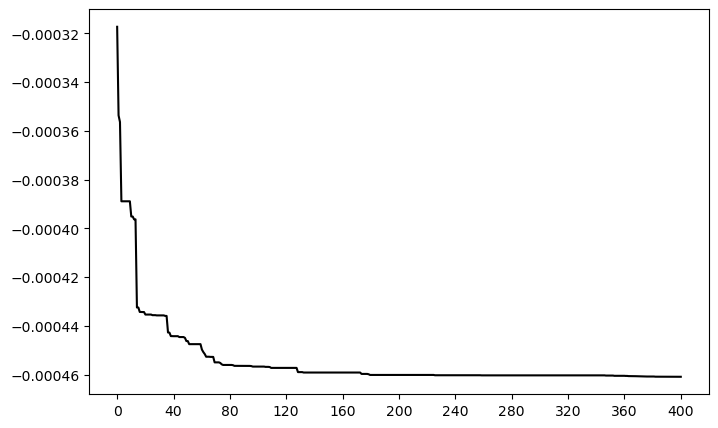

[-0.00046087]


In [178]:
best_nectar,result_by_iter = artificial_bee_colony(my_parameter, SP_mean_rtn, SP_cov_rtn, my_MR,0.6,1)
print(result_by_iter[-1])

In [133]:
# test
print(cal_ann_return_risk(best_nectar, SP_mean_rtn, SP_cov_rtn))
# print(result_by_iter)
weight = best_nectar.chromosome
for i, value in enumerate(weight, start=1):
    print(f"{i}: {value}")
print(best_nectar.dv)
print(sum(best_nectar.dv))
print(sum(best_nectar.chromosome))

[0.38505529 0.18755307]
1: 0.0010015089308977204
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 0.0
15: 0.0
16: 0.0
17: 0.1483123767994262
18: 0.0
19: 0.0
20: 0.0
21: 0.0
22: 0.0
23: 0.0
24: 0.0012110098982827916
25: 0.0
26: 0.0
27: 0.0
28: 0.0
29: 0.0
30: 0.0
31: 0.0
32: 0.0
33: 0.0
34: 0.0
35: 0.0
36: 0.0
37: 0.001000034151527242
38: 0.0
39: 0.0
40: 0.0
41: 0.0
42: 0.0
43: 0.0
44: 0.0
45: 0.0
46: 0.001000034151527242
47: 0.0
48: 0.0
49: 0.0
50: 0.0010089208061436613
51: 0.0
52: 0.0
53: 0.39981929912529096
54: 0.0
55: 0.0
56: 0.0
57: 0.0
58: 0.0
59: 0.0
60: 0.0
61: 0.0460935458581982
62: 0.0
63: 0.011892932111465155
64: 0.0
65: 0.0
66: 0.0
67: 0.0
68: 0.0
69: 0.28046089751467257
70: 0.001000034151527242
71: 0.0
72: 0.0
73: 0.0
74: 0.0
75: 0.0
76: 0.0
77: 0.0
78: 0.0
79: 0.0
80: 0.0
81: 0.0
82: 0.0
83: 0.0
84: 0.0
85: 0.0
86: 0.0
87: 0.10368944422063403
88: 0.0010204447634699137
89: 0.0
90: 0.0
91: 0.0010379312429874038
92: 0.0
93: 0.0
94: 0

In [173]:
result_by_iter

[array([-0.00036419]),
 array([-0.00036419]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00039832]),
 array([-0.00040046]),
 array([-0.00040046]),
 array([-0.00040345]),
 array([-0.00040345]),
 array([-0.00040345]),
 array([-0.00040345]),
 array([-0.00043558]),
 array([-0.00043632]),
 array([-0.00043736]),
 array([-0.00043815]),
 array([-0.00043815]),
 array([-0.00043815]),
 array([-0.00043815]),
 array([-0.00043815]),
 array([-0.00045002]),
 array([-0.00045002]),
 array([-0.00045002]),
 array([-0.00045002]),
 array([-0.00045002]),
 array([-0.00045002]),
 array([-0.00045024]),
 array([-0.00045027]),
 array([-0.00045027]),
 array([-0.00045027]),
 array([-0.00045027]),
 array([-0.00045036]),
 array([-0.00045036]),
 array([-0.00045068]),
 array([-0.00045068]),
 array([-0.00045068]),
 array([-0.00045113]),
 array([-0.00045113]),
 array([-0.

### 效率前沿测试

In [172]:
def main(mean_rtn, cov_rtn):
    """main function"""

    ef_set = []
    # ABC parameter 100 assets
    my_population = int(15 * np.sqrt(100))
    my_MCN = 400
    my_MR = 0.8
    num_of_rap = 40
    risk_averse_para_set = np.linspace(0.001, 1, num_of_rap)

    for i in range(num_of_rap):
        my_parameter = ParameterInformation(
            my_population, 100, 0.001, 0.4, 50, my_MCN, risk_averse_para_set[i], 15, 150)

        best_nectar = artificial_bee_colony(
            my_parameter, SP_mean_rtn, SP_cov_rtn, my_MR,0.6,1)
        result = cal_ann_return_risk(best_nectar, mean_rtn, cov_rtn)
        ef_set.append(result)
    return ef_set

Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.001


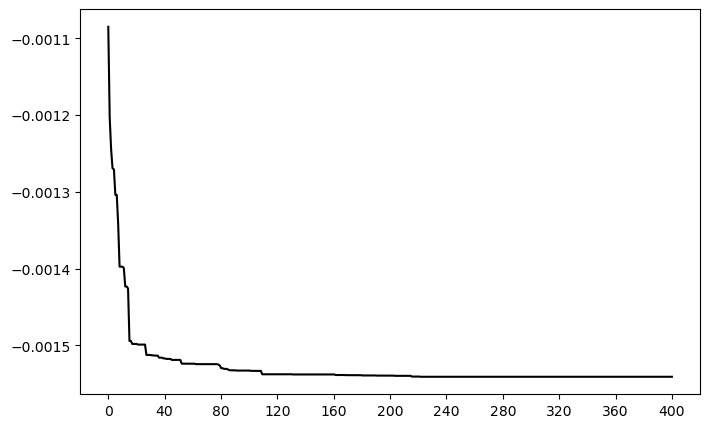

Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.026615384615384617


KeyboardInterrupt: 

In [119]:
ef_set = main(SP_mean_rtn, SP_cov_rtn)

In [117]:
ef_set

[array([0.38697354, 0.19926804]),
 array([0.38629238, 0.19370378]),
 array([0.38882117, 0.20023935]),
 array([0.38852682, 0.19985771]),
 array([0.38582173, 0.20022437]),
 array([0.38588978, 0.20073464]),
 array([0.38511993, 0.19973708]),
 array([0.38885222, 0.19989303]),
 array([0.38601866, 0.20090064]),
 array([0.38632569, 0.20102585]),
 array([0.38537229, 0.20044286]),
 array([0.38574265, 0.20089451]),
 array([0.38627306, 0.19196985]),
 array([0.38476755, 0.2003715 ]),
 array([0.38504179, 0.19960696]),
 array([0.38608232, 0.19817794]),
 array([0.38481446, 0.1988898 ]),
 array([0.38869283, 0.19846586]),
 array([0.38554054, 0.19814052]),
 array([0.38545538, 0.19795376]),
 array([0.38838471, 0.19914939]),
 array([0.38597614, 0.20015474]),
 array([0.3827716 , 0.19146357]),
 array([0.38365423, 0.18991102]),
 array([0.38480906, 0.1975857 ]),
 array([0.38696997, 0.19308926]),
 array([0.38120719, 0.18825685]),
 array([0.37105622, 0.17775414]),
 array([0.37235502, 0.18064152]),
 array([0.3824

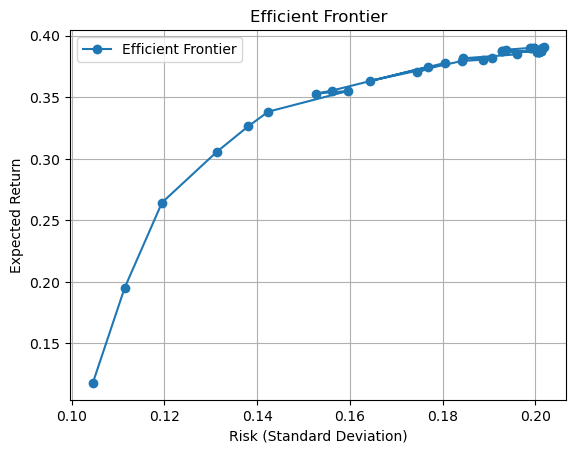

In [113]:
draw_ef(ef_set)

In [115]:
ef_set_5 = ef_set
%store ef_set_5

Stored 'ef_set_5' (list)


In [54]:
ef_set
df = pd.DataFrame(ef_set, columns=['abc-return', 'abc-risk'])
df.to_csv('abc-ef.csv', index=False)

In [116]:
# save result
result_path = "/Users/bianhanzhang/Desktop/Coding/MY-ABC/result/abc-ef.csv"
result_sheet = pd.read_csv(result_path)
result_sheet["3 step global 100 population return"] = pd.DataFrame([data[0] for data in ef_set])
result_sheet["3 step global 100 population risk"] = pd.DataFrame([data[1] for data in ef_set])
result_sheet.to_csv(result_path, index=False)

In [346]:
def cal_ann_return_risk(weight, mean_rtn, cov_rtn):
    """calculate annual return and risk"""
    ann_rtn = np.dot(weight, mean_rtn) * 252  # trading days: 252
    ann_risk = np.sqrt(np.dot(np.dot(weight, cov_rtn), weight.T) * 252)
    result = np.array([ann_rtn.item(), ann_risk])
    return result

[I 2024-06-18 02:15:49,814] A new study created in memory with name: no-name-da4e8b28-1a22-4228-abb8-67e3c1e23ecf


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


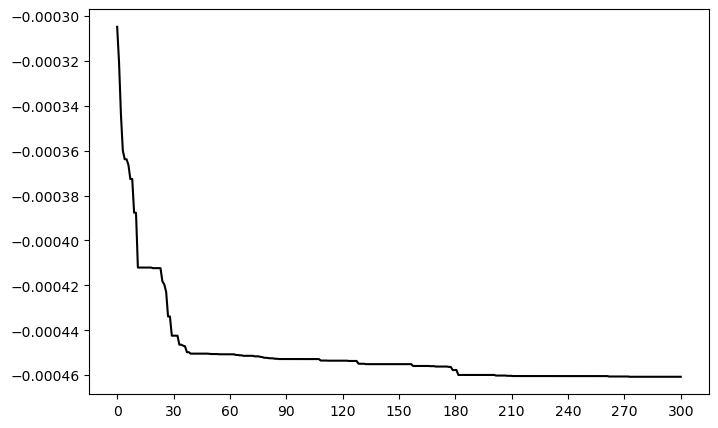

[I 2024-06-18 02:19:40,801] Trial 0 finished with value: -0.00046070900127871645 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


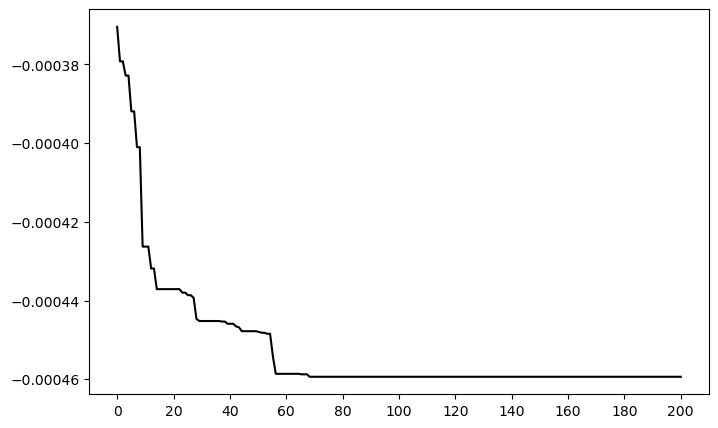

[I 2024-06-18 02:22:11,692] Trial 1 finished with value: -0.000459373838536686 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 200, 'SPP': 100}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


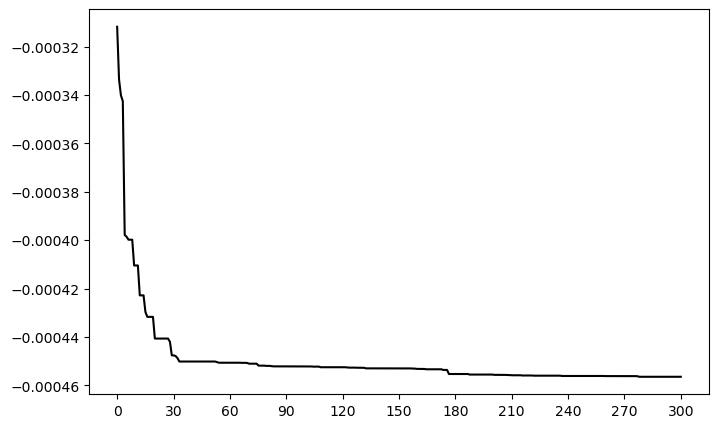

[I 2024-06-18 02:29:51,718] Trial 2 finished with value: -0.00045646854859975224 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


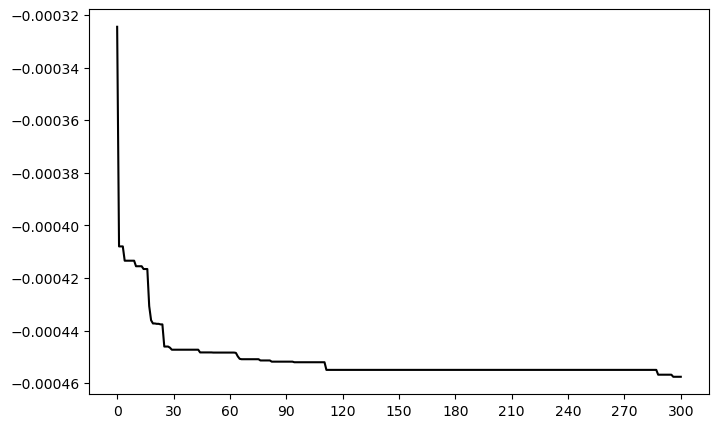

[I 2024-06-18 02:32:50,641] Trial 3 finished with value: -0.0004575968801311158 and parameters: {'population_size': 100, 'limit': 25, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


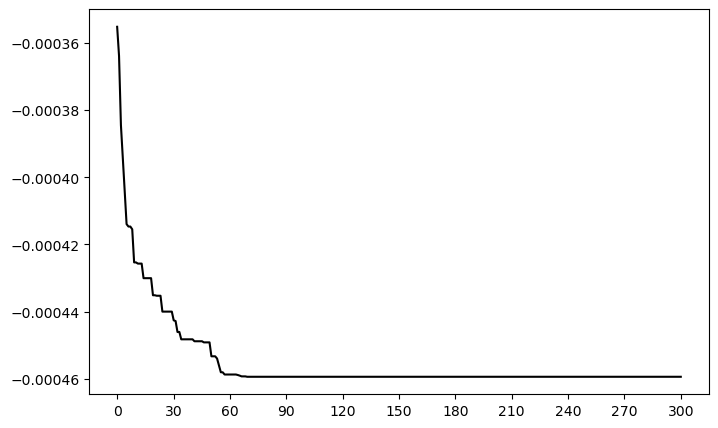

[I 2024-06-18 02:38:24,958] Trial 4 finished with value: -0.0004593989789715816 and parameters: {'population_size': 200, 'limit': 25, 'max_algo_iter_nums': 300, 'SPP': 100}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


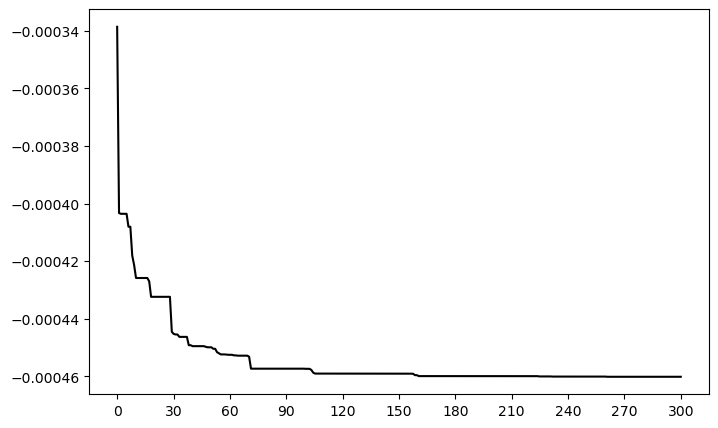

[I 2024-06-18 02:42:46,205] Trial 5 finished with value: -0.0004601638533213333 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 100}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


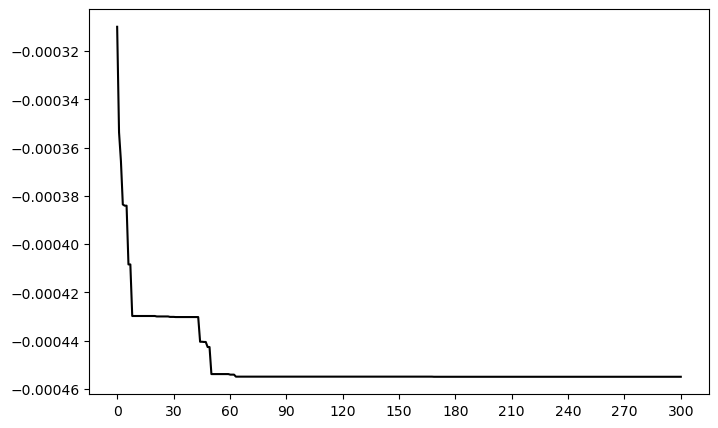

[I 2024-06-18 02:43:29,384] Trial 6 finished with value: -0.0004549916091512859 and parameters: {'population_size': 50, 'limit': 50, 'max_algo_iter_nums': 300, 'SPP': 100}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


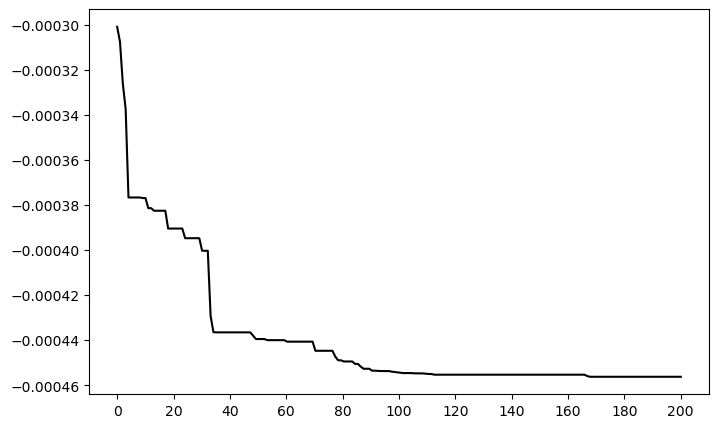

[I 2024-06-18 02:43:55,271] Trial 7 finished with value: -0.00045620885076870927 and parameters: {'population_size': 50, 'limit': 50, 'max_algo_iter_nums': 200, 'SPP': 150}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


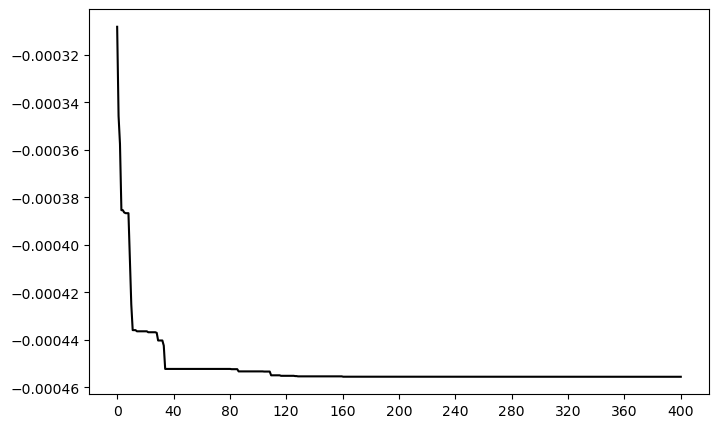

[I 2024-06-18 02:44:50,774] Trial 8 finished with value: -0.0004555021748439265 and parameters: {'population_size': 50, 'limit': 50, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


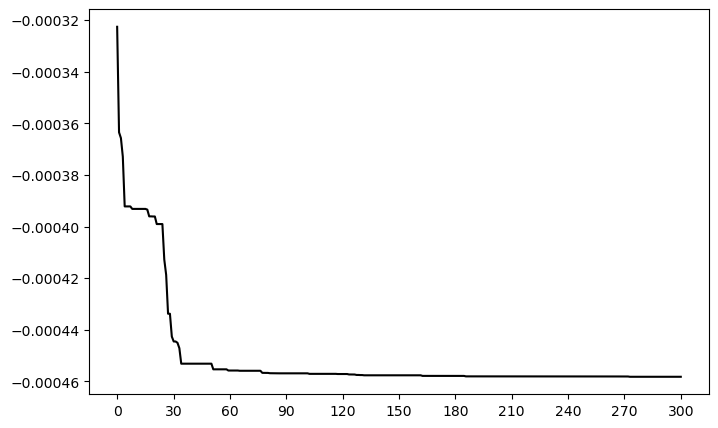

[I 2024-06-18 02:46:34,666] Trial 9 finished with value: -0.0004582232207179666 and parameters: {'population_size': 100, 'limit': 50, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


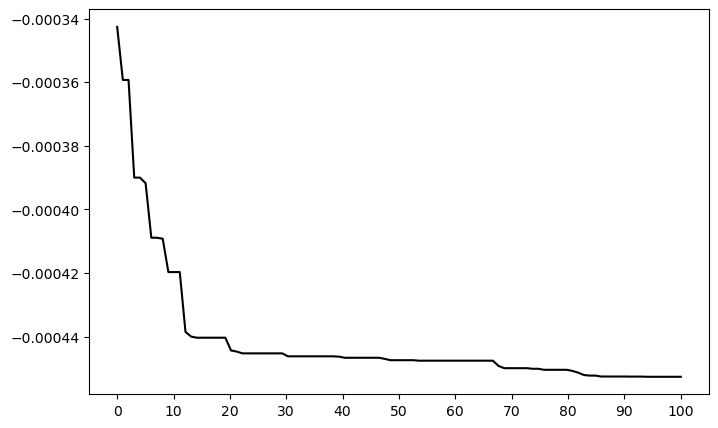

[I 2024-06-18 02:47:36,197] Trial 10 finished with value: -0.00045260796141757706 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 100, 'SPP': 150}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


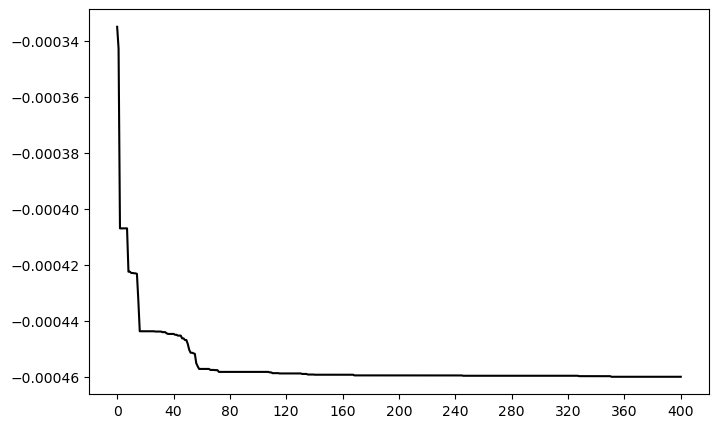

[I 2024-06-18 02:55:55,905] Trial 11 finished with value: -0.0004600484061811049 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 100}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


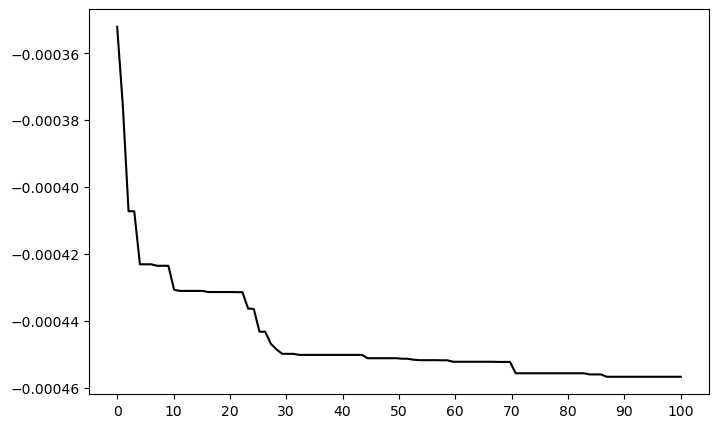

[I 2024-06-18 02:56:58,183] Trial 12 finished with value: -0.0004566646711577039 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 100, 'SPP': 50}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


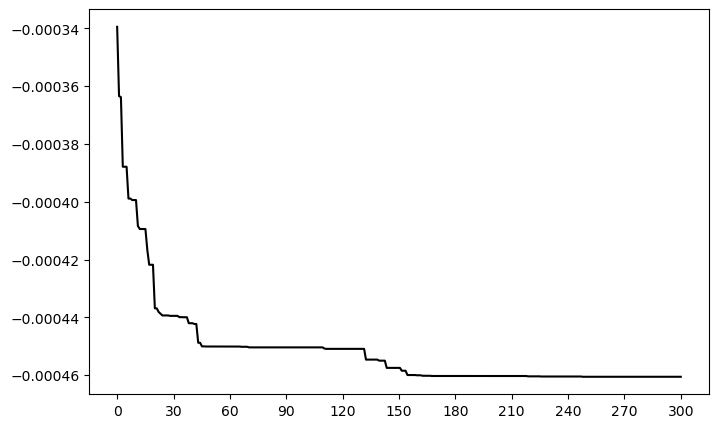

[I 2024-06-18 03:01:40,990] Trial 13 finished with value: -0.0004605763676012405 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 100}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


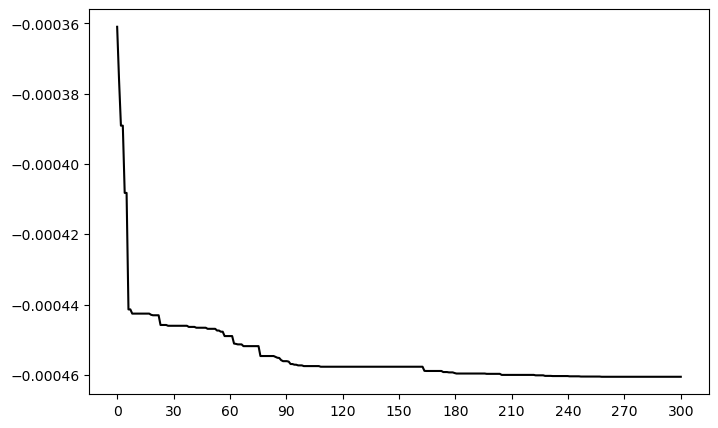

[I 2024-06-18 03:08:19,003] Trial 14 finished with value: -0.0004605663010053088 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 150}. Best is trial 0 with value: -0.00046070900127871645.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


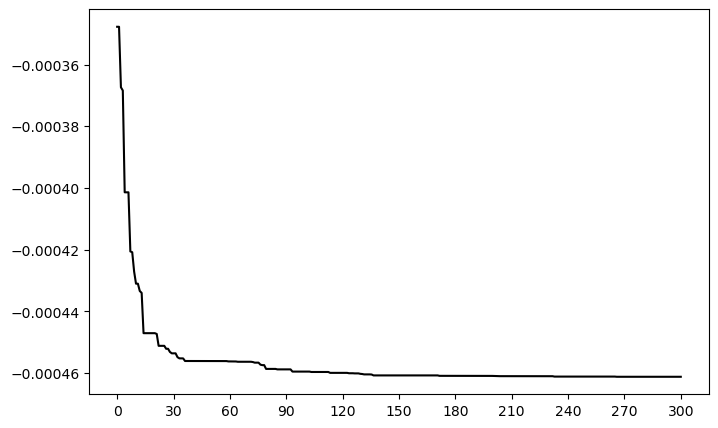

[I 2024-06-18 03:11:32,744] Trial 15 finished with value: -0.00046116932667237816 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 15 with value: -0.00046116932667237816.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


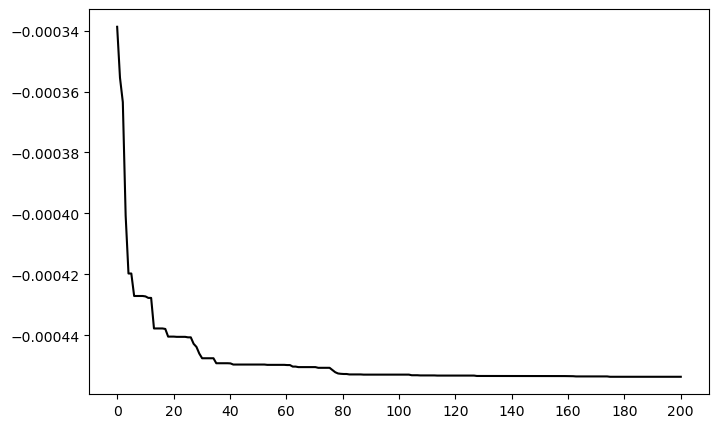

[I 2024-06-18 03:13:43,461] Trial 16 finished with value: -0.00045358334501236245 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 200, 'SPP': 50}. Best is trial 15 with value: -0.00046116932667237816.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


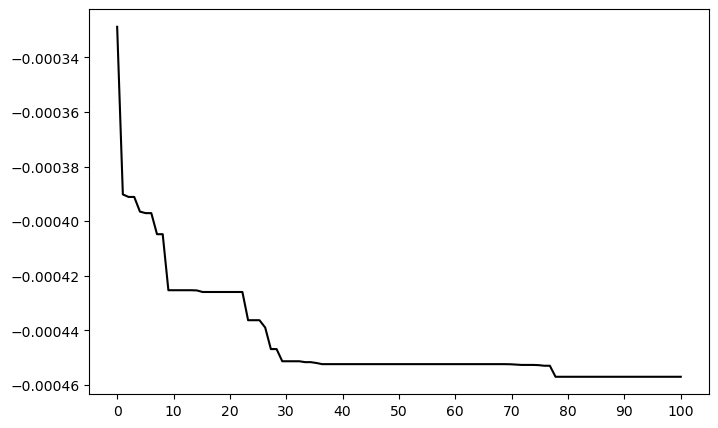

[I 2024-06-18 03:14:48,374] Trial 17 finished with value: -0.0004569862431936264 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 100, 'SPP': 50}. Best is trial 15 with value: -0.00046116932667237816.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


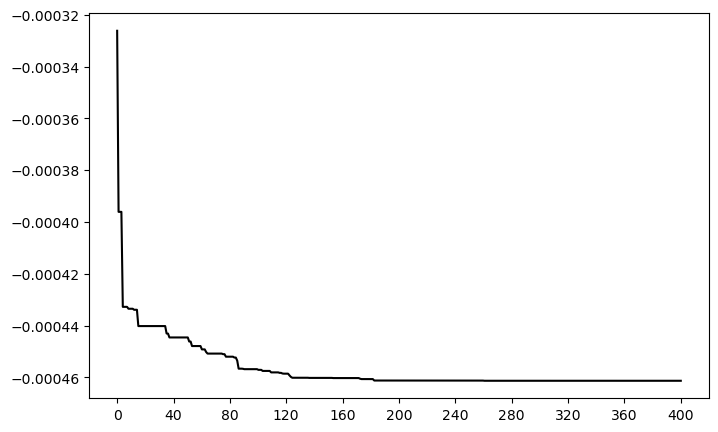

[I 2024-06-18 03:19:02,935] Trial 18 finished with value: -0.00046130327343661773 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


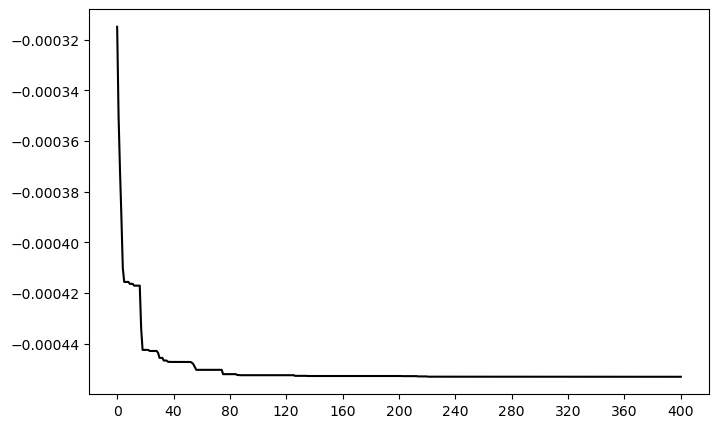

[I 2024-06-18 03:23:28,673] Trial 19 finished with value: -0.0004530387849262396 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


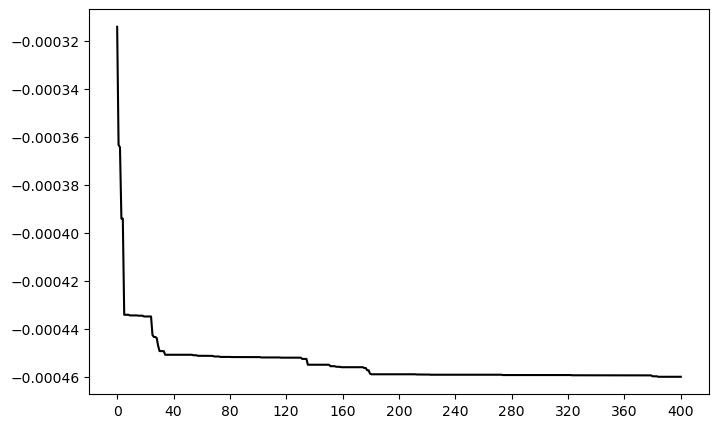

[I 2024-06-18 03:27:47,944] Trial 20 finished with value: -0.0004597961201030766 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


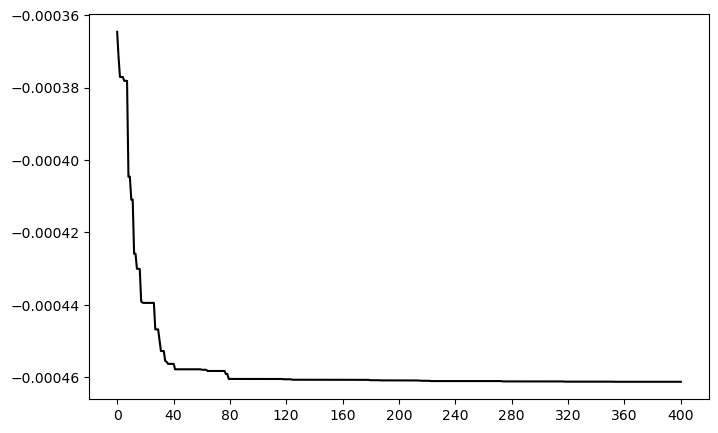

[I 2024-06-18 03:32:16,474] Trial 21 finished with value: -0.0004612594731745396 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


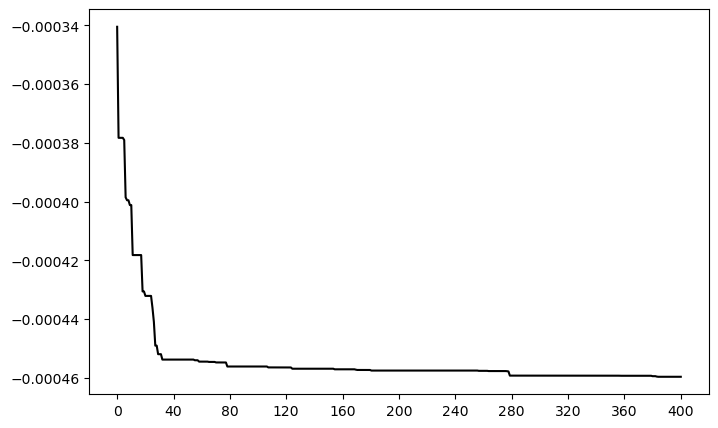

[I 2024-06-18 03:36:37,052] Trial 22 finished with value: -0.0004595612742655721 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


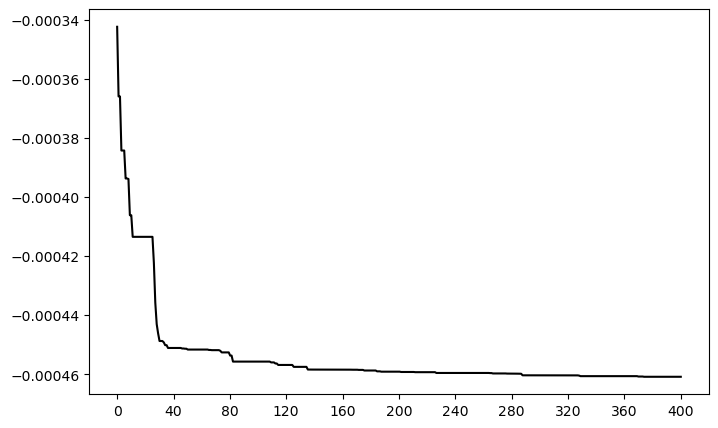

[I 2024-06-18 03:41:03,459] Trial 23 finished with value: -0.0004608410228557798 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


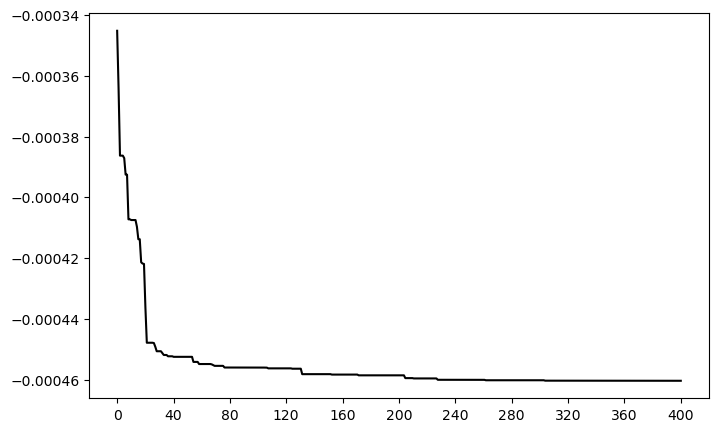

[I 2024-06-18 03:45:29,009] Trial 24 finished with value: -0.00046030571248081495 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


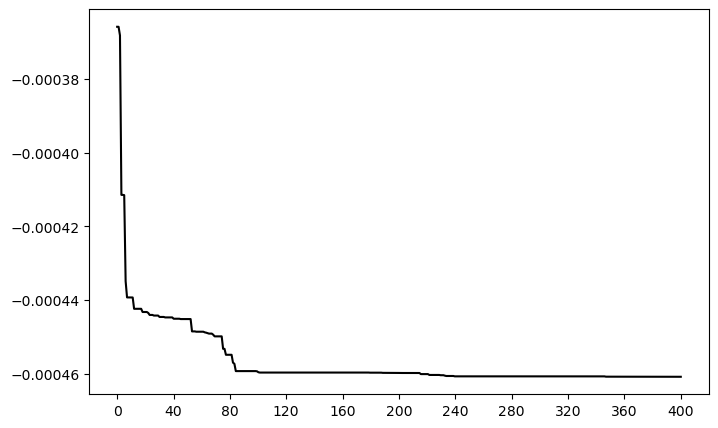

[I 2024-06-18 03:48:06,608] Trial 25 finished with value: -0.00046084839269566974 and parameters: {'population_size': 100, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 150}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


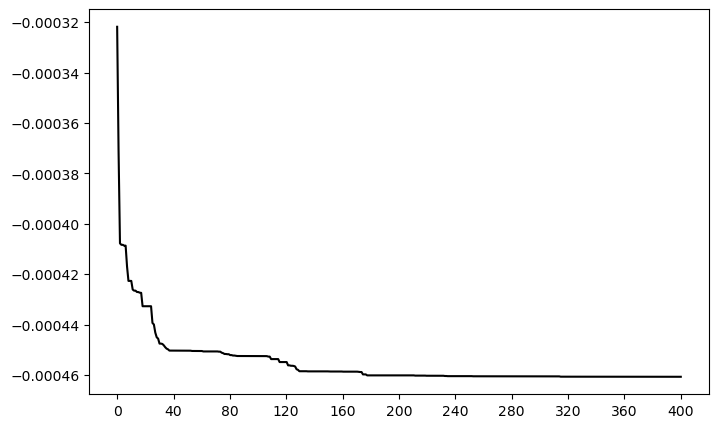

[I 2024-06-18 03:57:02,409] Trial 26 finished with value: -0.00046070725383276886 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


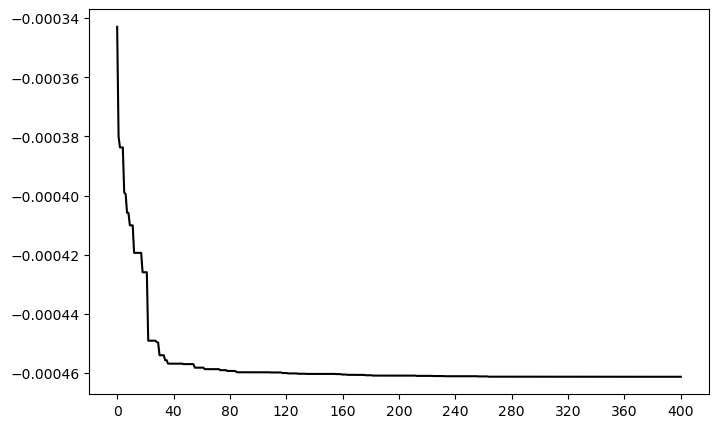

[I 2024-06-18 04:01:33,694] Trial 27 finished with value: -0.0004612574975366024 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


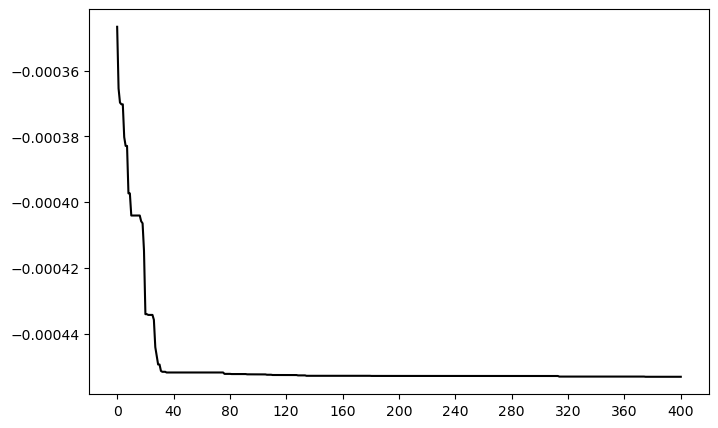

[I 2024-06-18 04:06:01,268] Trial 28 finished with value: -0.0004531134510540527 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


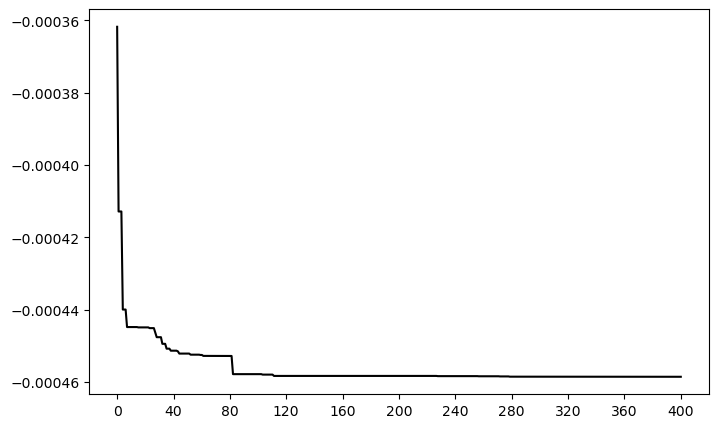

[I 2024-06-18 04:10:28,270] Trial 29 finished with value: -0.0004585226124261474 and parameters: {'population_size': 150, 'limit': 50, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


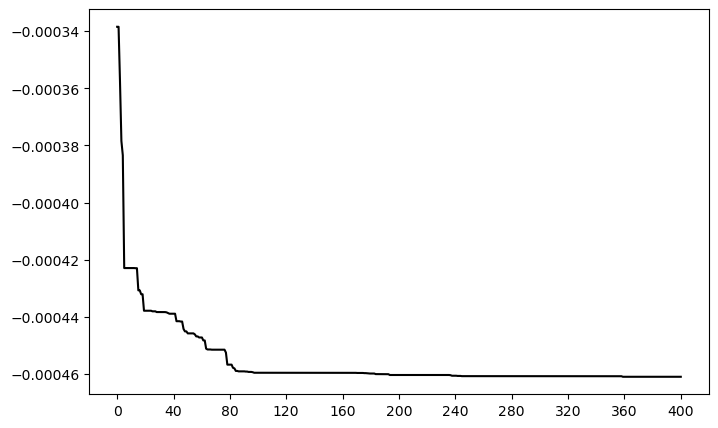

[I 2024-06-18 04:14:53,865] Trial 30 finished with value: -0.00046106647269780857 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 150}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


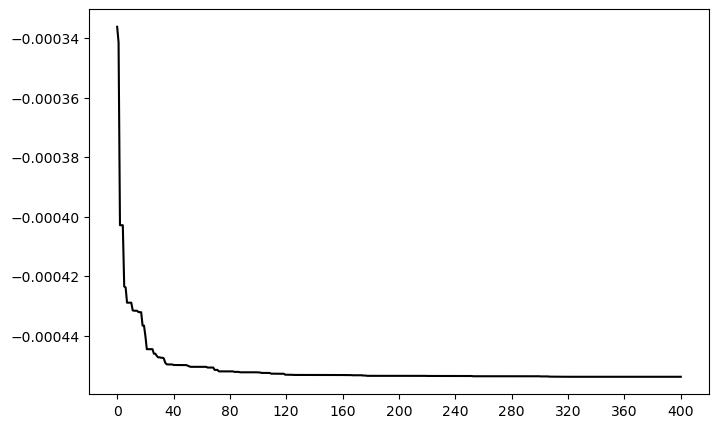

[I 2024-06-18 04:19:22,345] Trial 31 finished with value: -0.00045387383212420714 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


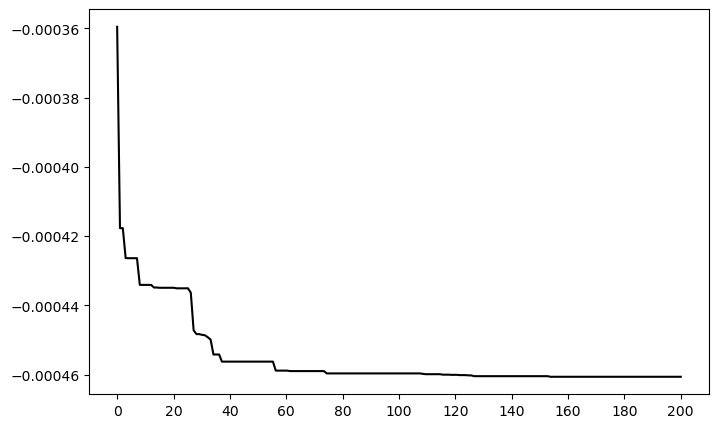

[I 2024-06-18 04:21:34,735] Trial 32 finished with value: -0.00046061093364623814 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 200, 'SPP': 50}. Best is trial 18 with value: -0.00046130327343661773.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


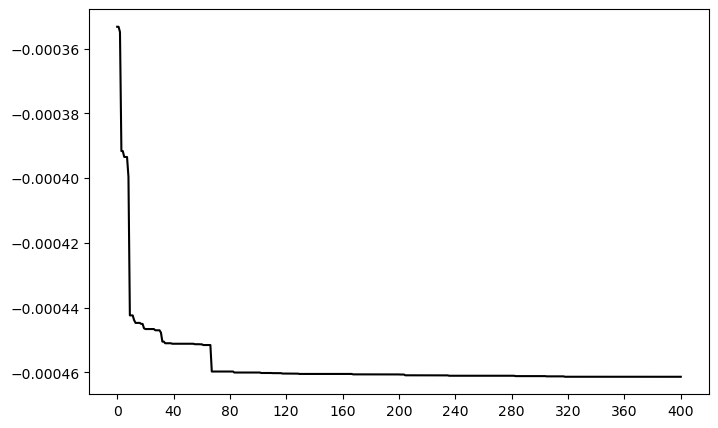

[I 2024-06-18 04:26:04,363] Trial 33 finished with value: -0.00046135702787007476 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


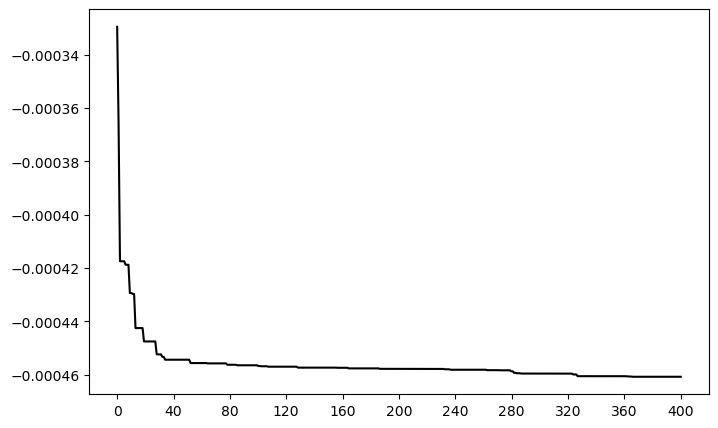

[I 2024-06-18 04:30:32,072] Trial 34 finished with value: -0.00046078380598659955 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


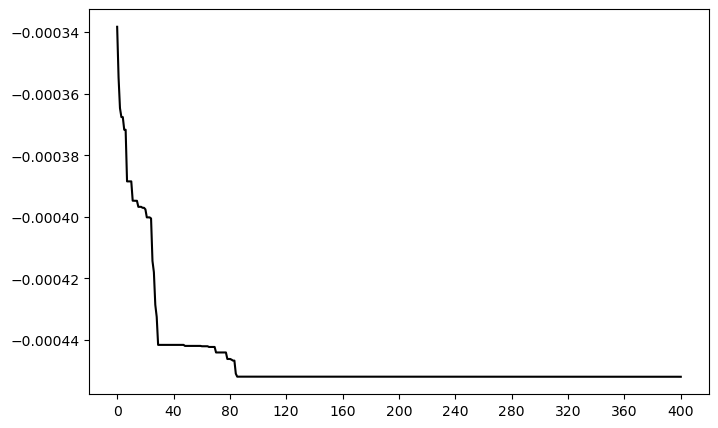

[I 2024-06-18 04:33:12,283] Trial 35 finished with value: -0.00045193323426899186 and parameters: {'population_size': 100, 'limit': 25, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


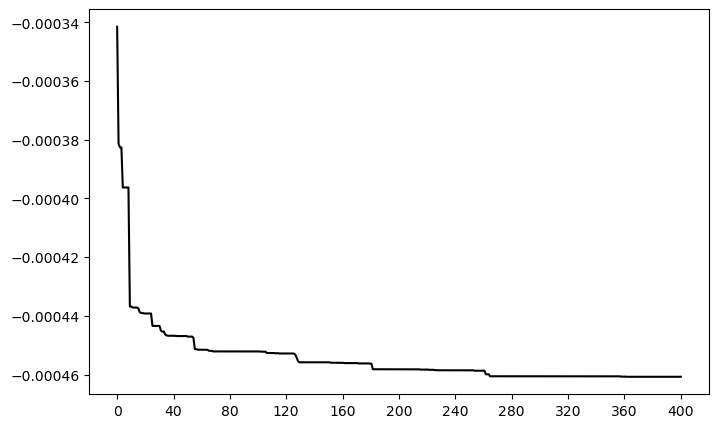

[I 2024-06-18 04:39:46,554] Trial 36 finished with value: -0.0004607216294559539 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


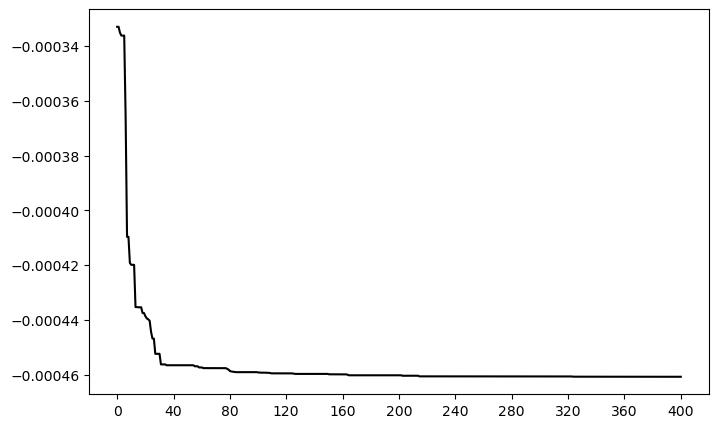

[I 2024-06-18 04:40:50,176] Trial 37 finished with value: -0.00046079875978851824 and parameters: {'population_size': 50, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


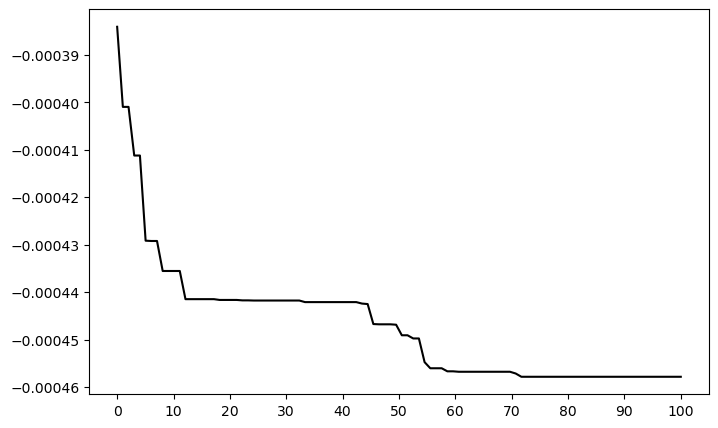

[I 2024-06-18 04:41:57,664] Trial 38 finished with value: -0.00045783431866880376 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 100, 'SPP': 100}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


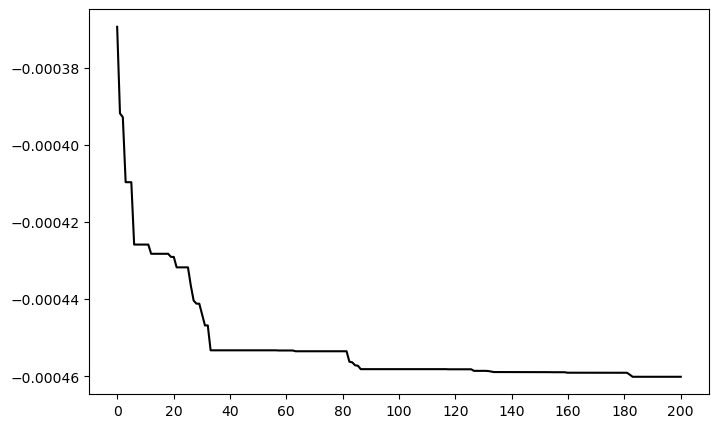

[I 2024-06-18 04:46:35,385] Trial 39 finished with value: -0.000460087011096832 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 200, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


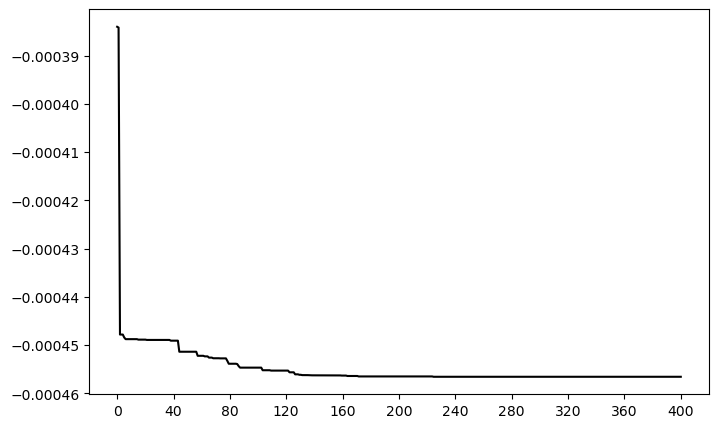

[I 2024-06-18 04:47:40,181] Trial 40 finished with value: -0.00045656812477702375 and parameters: {'population_size': 50, 'limit': 50, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


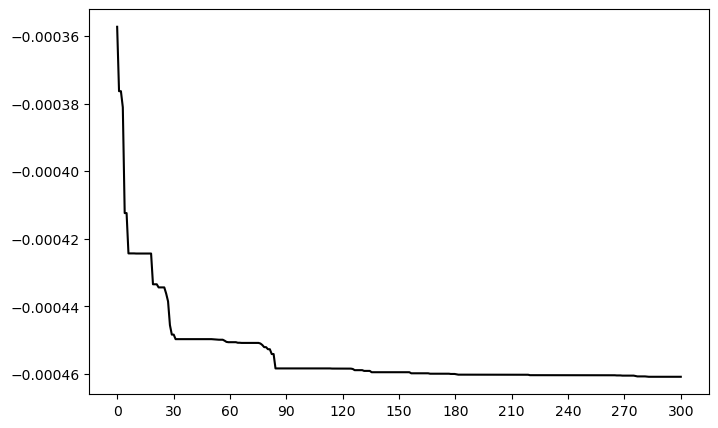

[I 2024-06-18 04:51:01,338] Trial 41 finished with value: -0.00046085332111549997 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


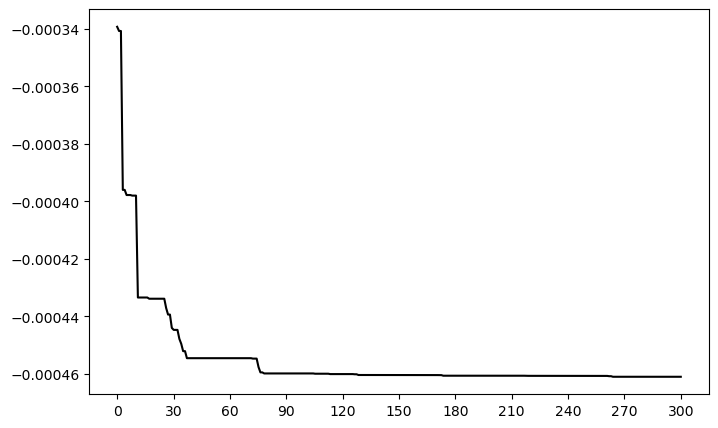

[I 2024-06-18 04:54:27,509] Trial 42 finished with value: -0.0004609897291401973 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


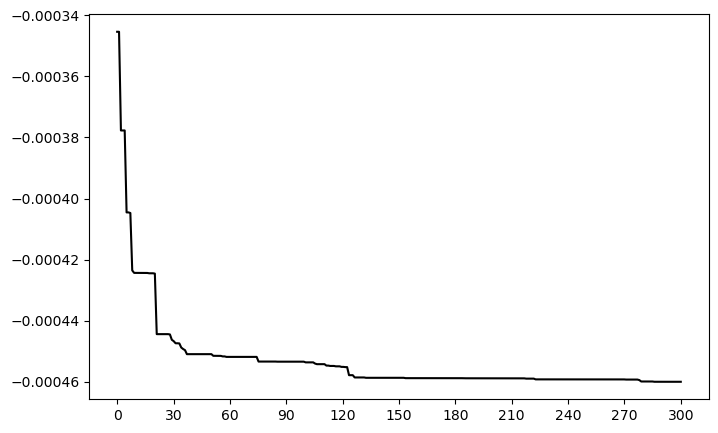

[I 2024-06-18 04:57:47,534] Trial 43 finished with value: -0.00045999340109355844 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


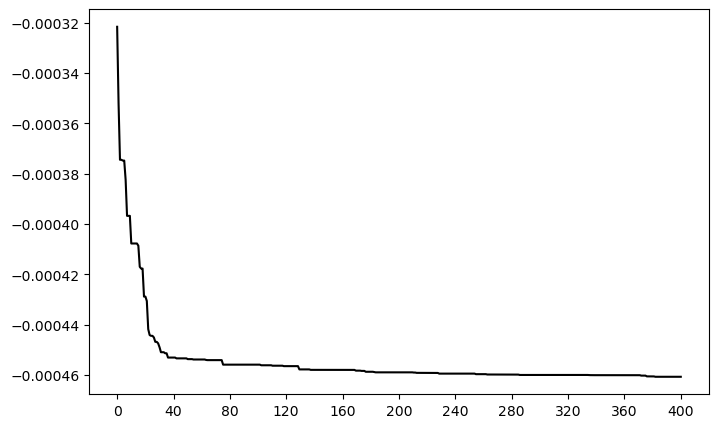

[I 2024-06-18 05:02:19,965] Trial 44 finished with value: -0.00046072526550691766 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


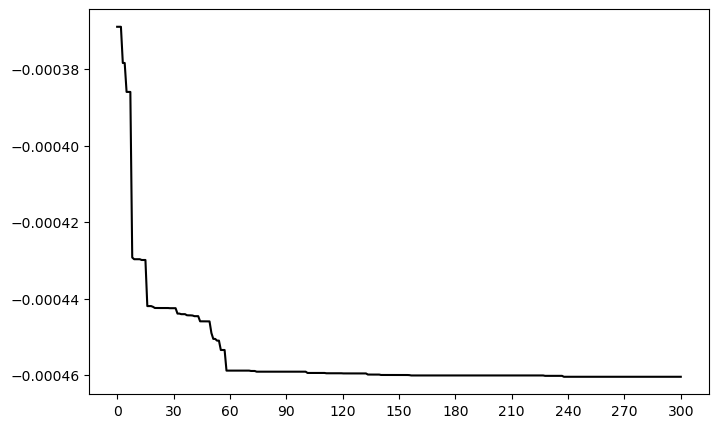

[I 2024-06-18 05:07:22,031] Trial 45 finished with value: -0.0004604006992718147 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 100}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


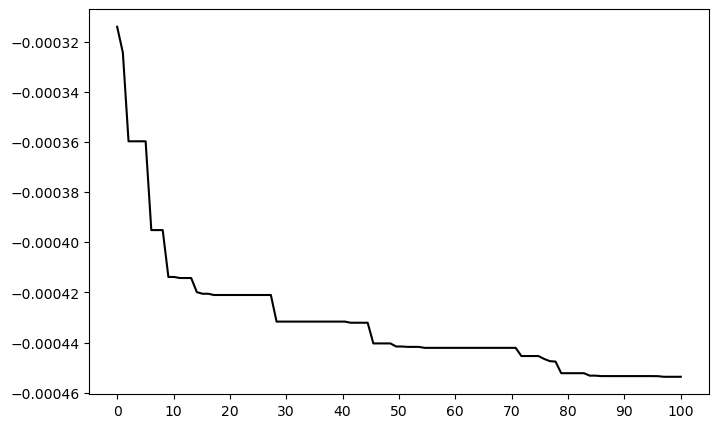

[I 2024-06-18 05:08:00,916] Trial 46 finished with value: -0.0004536581582557749 and parameters: {'population_size': 100, 'limit': 50, 'max_algo_iter_nums': 100, 'SPP': 150}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


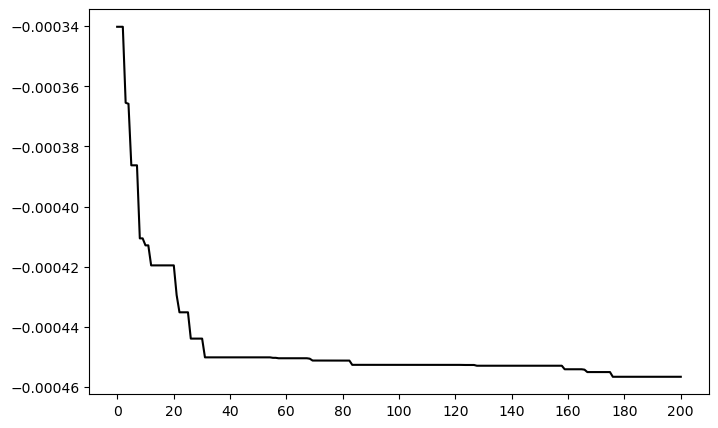

[I 2024-06-18 05:10:19,602] Trial 47 finished with value: -0.0004566169602640801 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 200, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


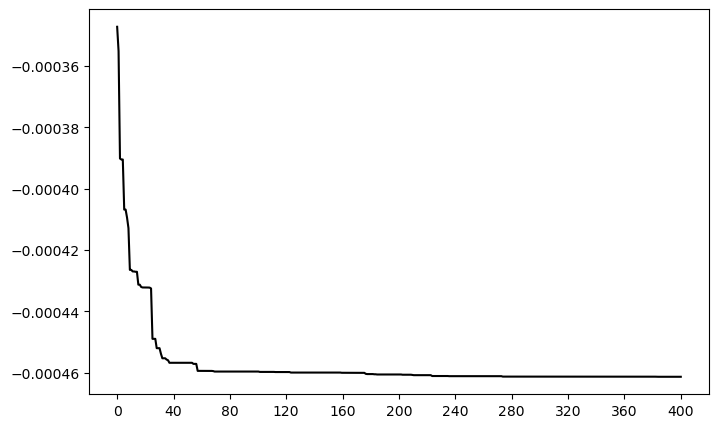

[I 2024-06-18 05:14:47,079] Trial 48 finished with value: -0.0004613100898921223 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


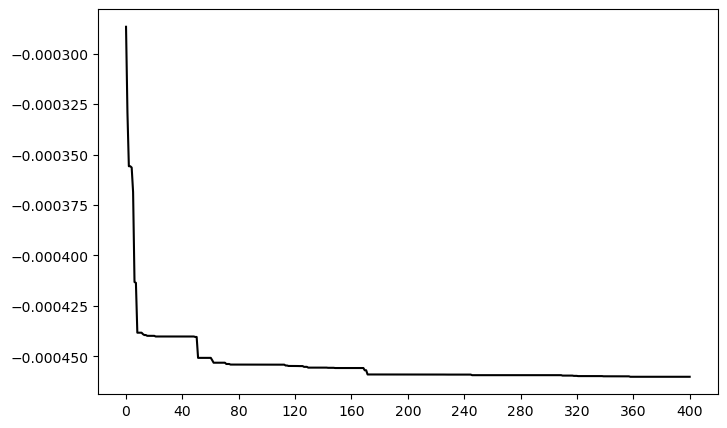

[I 2024-06-18 05:15:51,514] Trial 49 finished with value: -0.00046008784544517055 and parameters: {'population_size': 50, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 100}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


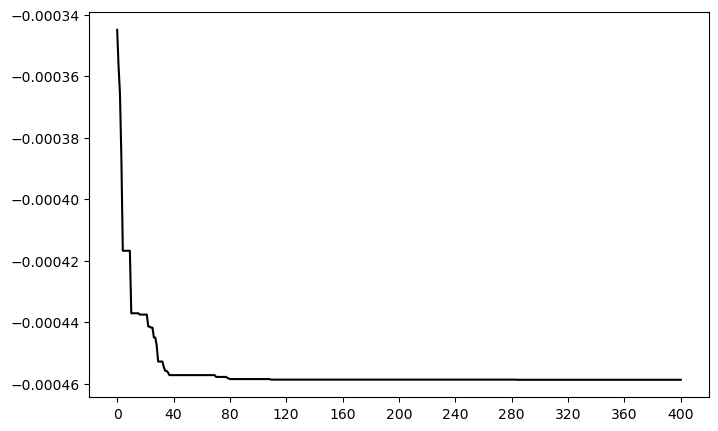

[I 2024-06-18 05:20:21,602] Trial 50 finished with value: -0.0004587693014911549 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


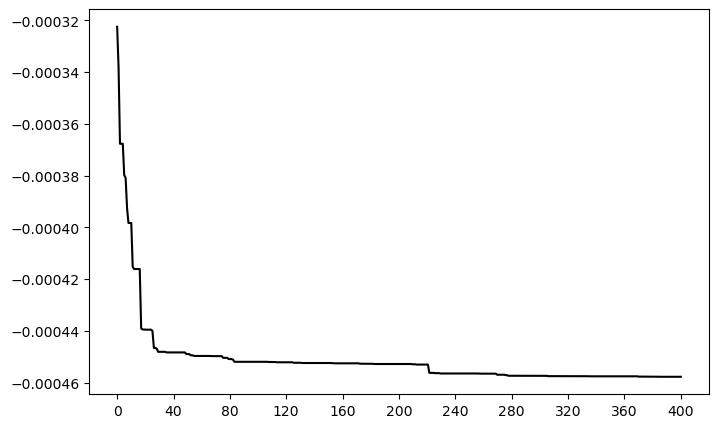

[I 2024-06-18 05:24:45,119] Trial 51 finished with value: -0.0004576731556219157 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


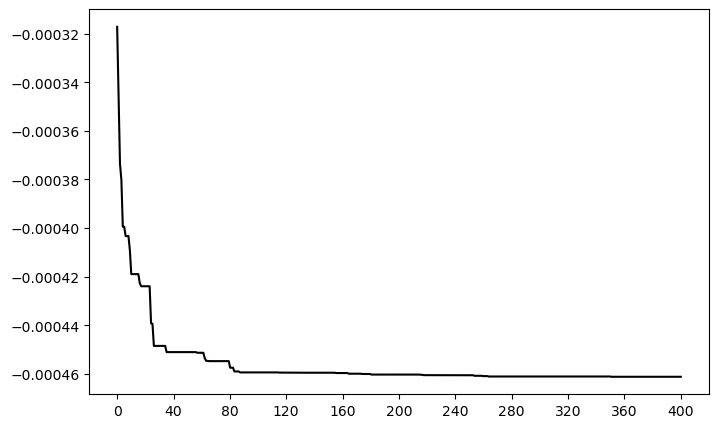

[I 2024-06-18 05:29:21,025] Trial 52 finished with value: -0.00046117609700574707 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


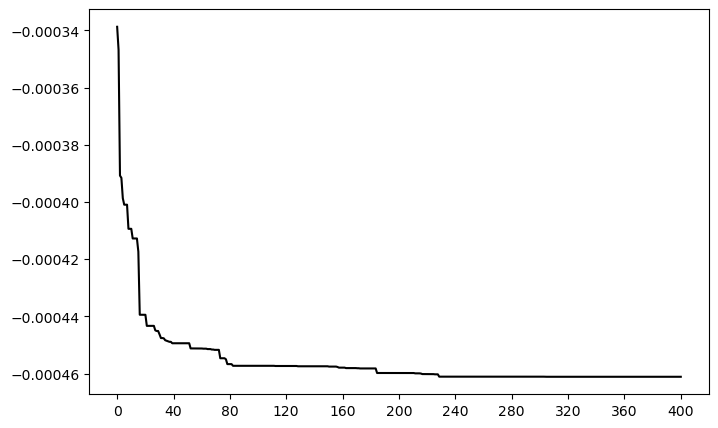

[I 2024-06-18 05:33:50,117] Trial 53 finished with value: -0.0004611123326653233 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


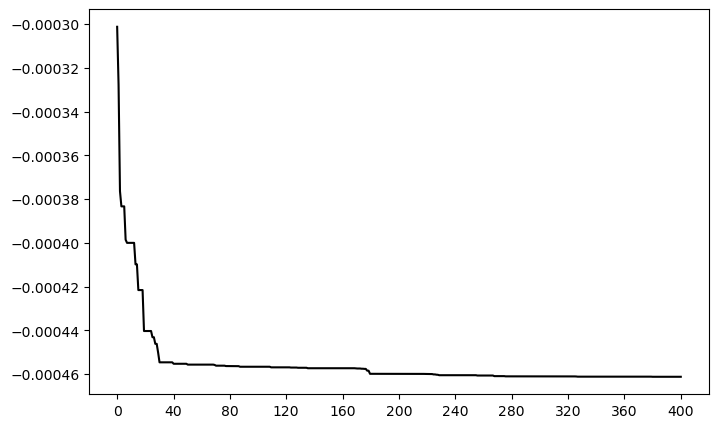

[I 2024-06-18 05:38:25,320] Trial 54 finished with value: -0.0004612636147358229 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


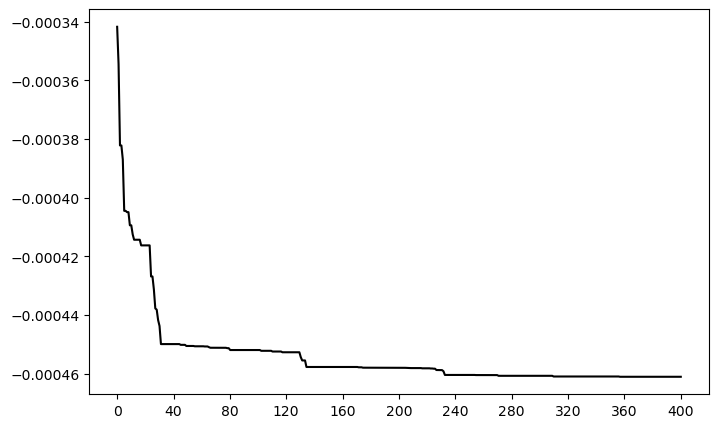

[I 2024-06-18 05:45:08,630] Trial 55 finished with value: -0.00046098609805327604 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


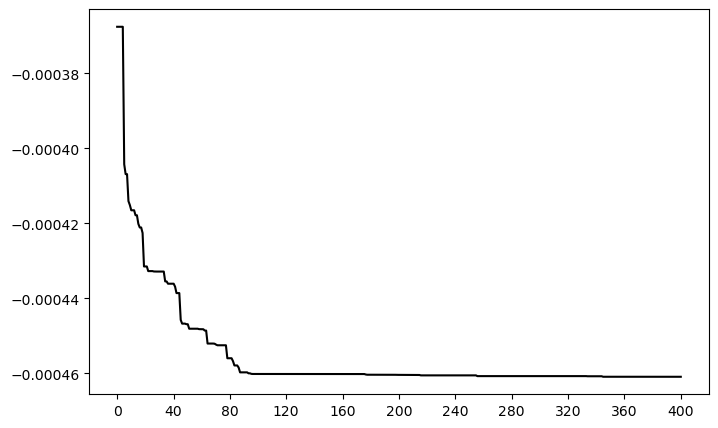

[I 2024-06-18 05:54:32,412] Trial 56 finished with value: -0.000460881310741717 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 150}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


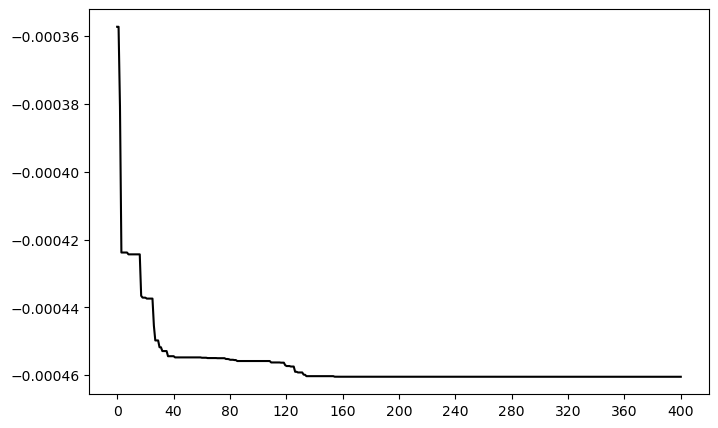

[I 2024-06-18 05:59:11,068] Trial 57 finished with value: -0.0004604464382177824 and parameters: {'population_size': 150, 'limit': 50, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


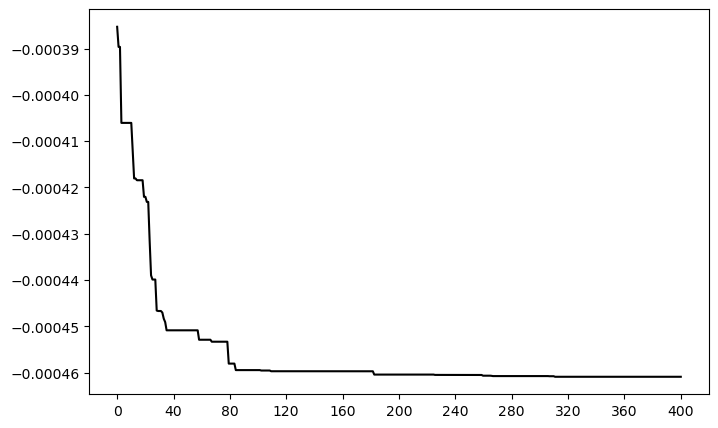

[I 2024-06-18 06:03:42,993] Trial 58 finished with value: -0.0004608924483770012 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


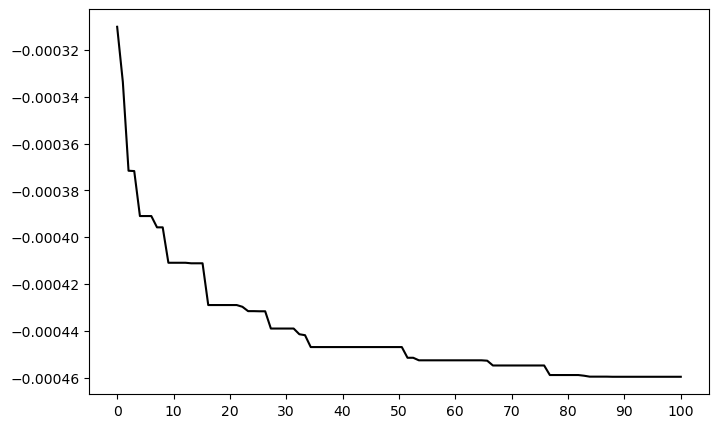

[I 2024-06-18 06:04:52,322] Trial 59 finished with value: -0.0004596322446859404 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 100, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


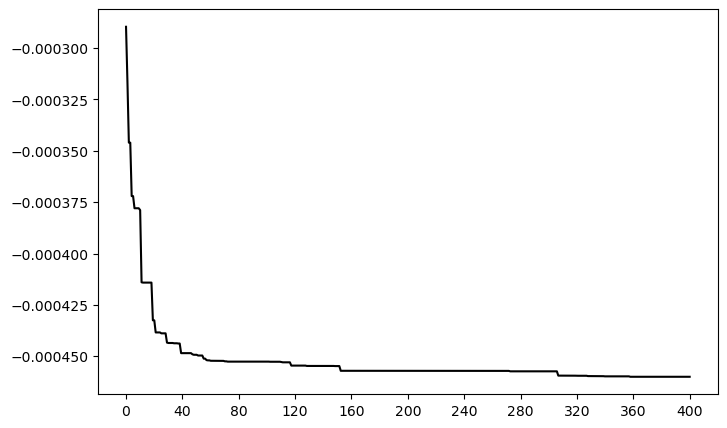

[I 2024-06-18 06:07:34,350] Trial 60 finished with value: -0.0004599806933209362 and parameters: {'population_size': 100, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 100}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


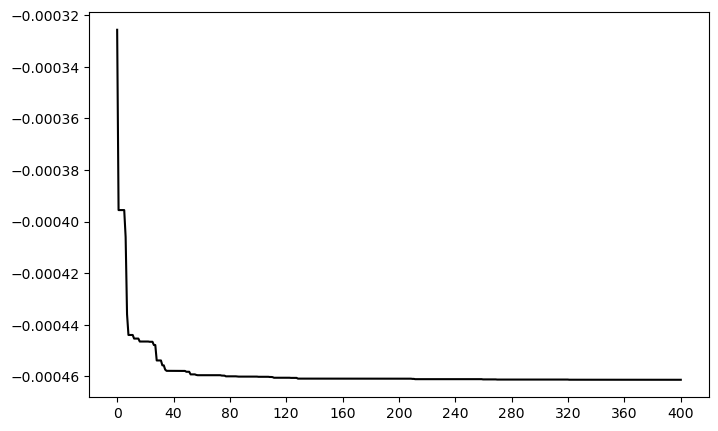

[I 2024-06-18 06:12:10,389] Trial 61 finished with value: -0.0004613020114805668 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


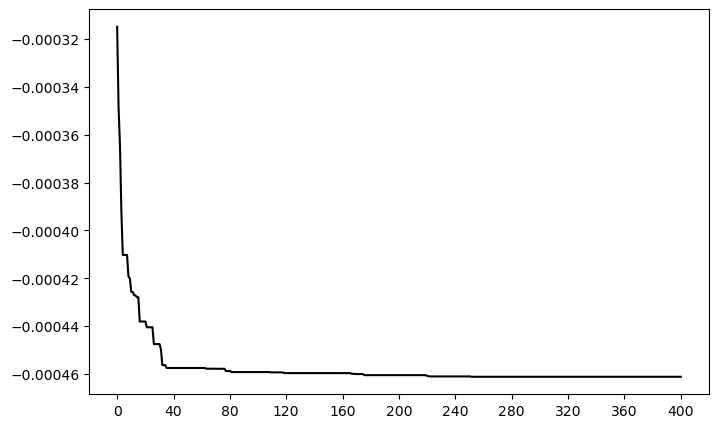

[I 2024-06-18 06:16:40,859] Trial 62 finished with value: -0.00046115541883496366 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


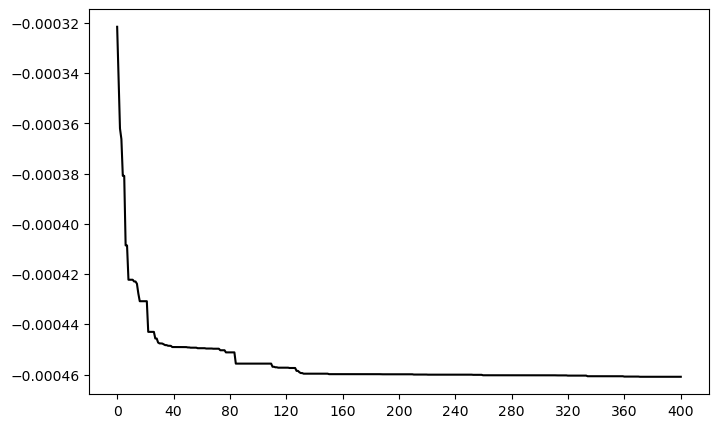

[I 2024-06-18 06:21:14,877] Trial 63 finished with value: -0.00046090188341473844 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


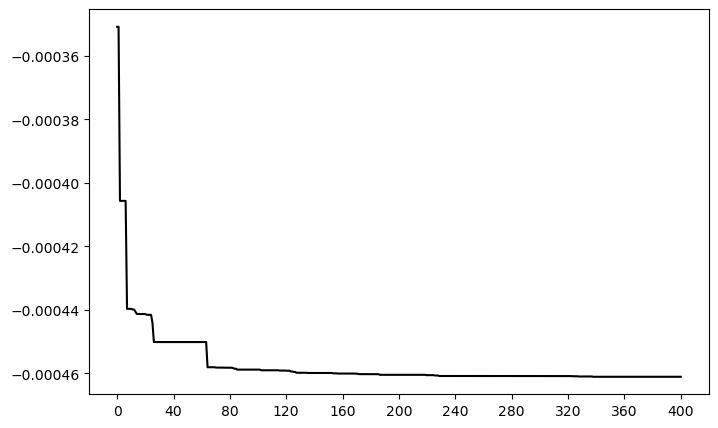

[I 2024-06-18 06:25:40,003] Trial 64 finished with value: -0.00046104327433498616 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 33 with value: -0.00046135702787007476.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


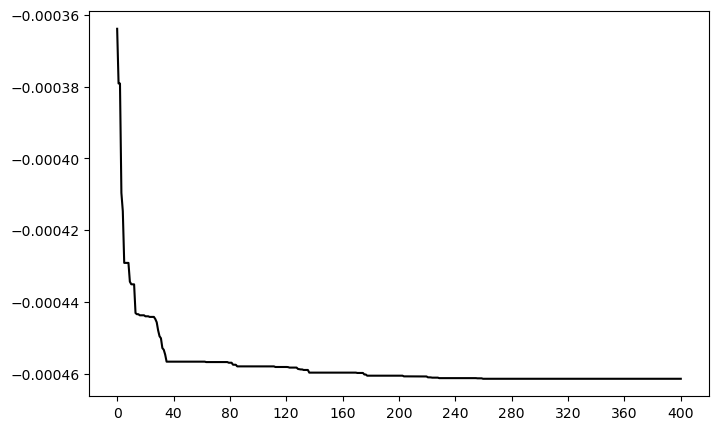

[I 2024-06-18 06:30:05,495] Trial 65 finished with value: -0.0004613828640520799 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


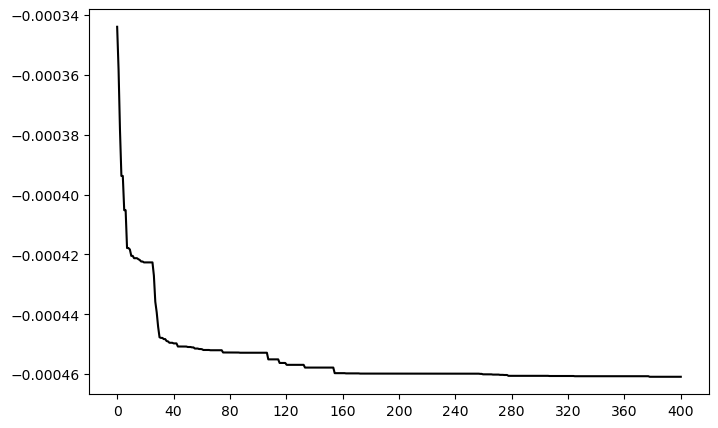

[I 2024-06-18 06:34:36,565] Trial 66 finished with value: -0.0004608743023591764 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


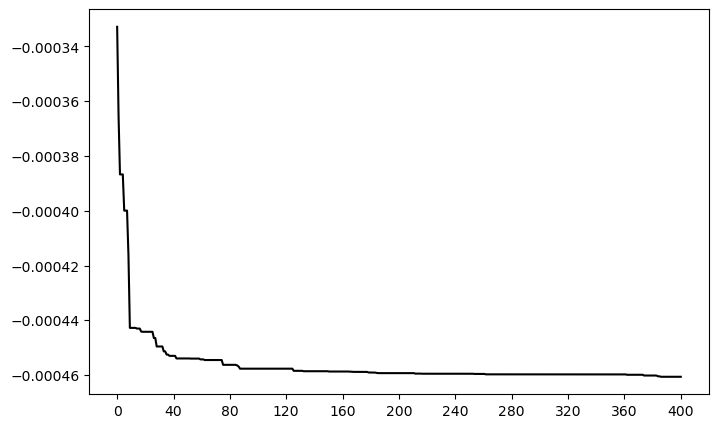

[I 2024-06-18 06:39:06,290] Trial 67 finished with value: -0.00046063848627880995 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


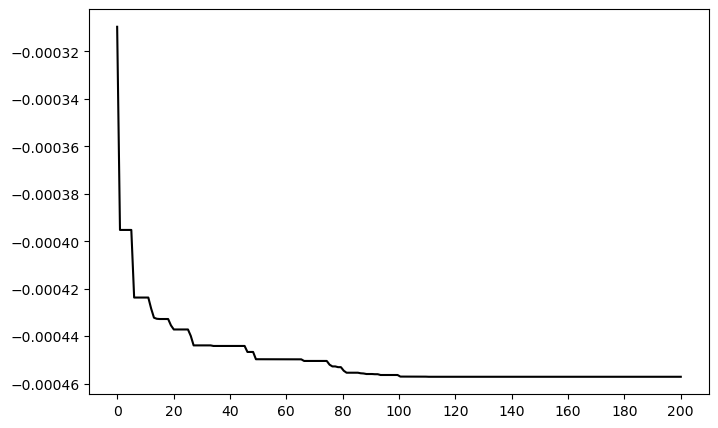

[I 2024-06-18 06:41:28,582] Trial 68 finished with value: -0.0004571139016513747 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 200, 'SPP': 150}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


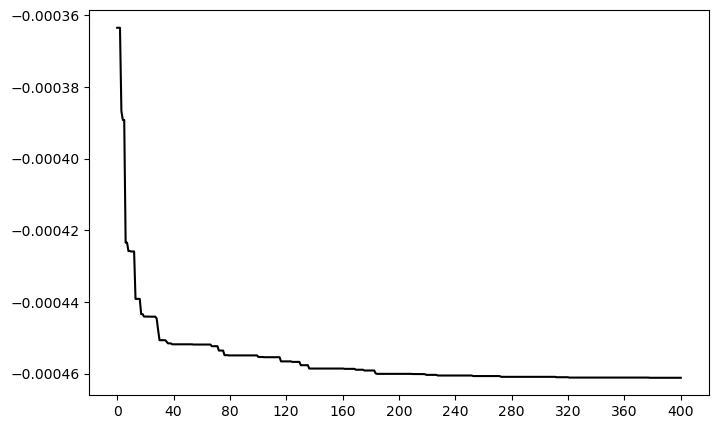

[I 2024-06-18 06:50:44,820] Trial 69 finished with value: -0.0004611143336170717 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


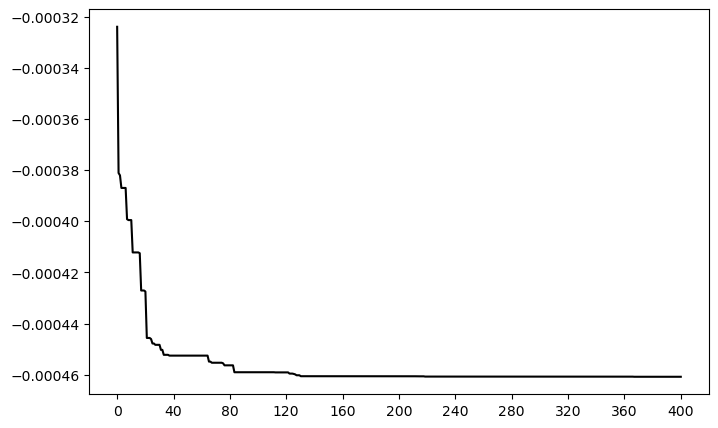

[I 2024-06-18 06:55:18,123] Trial 70 finished with value: -0.00046080320314967034 and parameters: {'population_size': 150, 'limit': 50, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


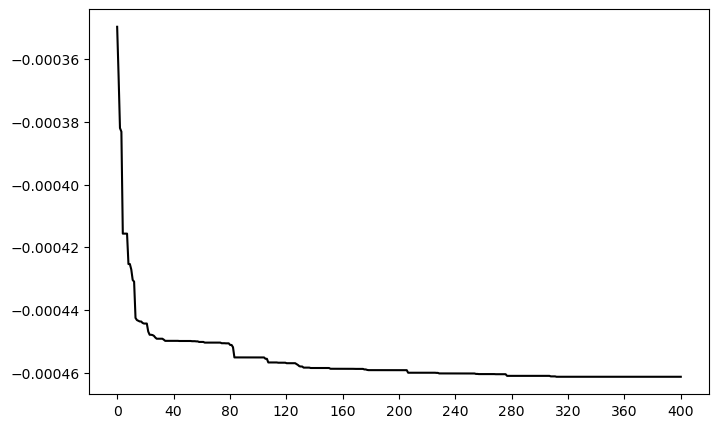

[I 2024-06-18 06:59:51,317] Trial 71 finished with value: -0.0004613516765707728 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


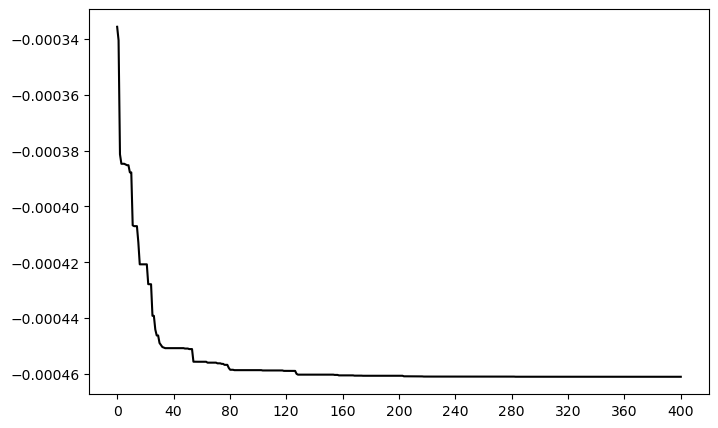

[I 2024-06-18 07:04:25,097] Trial 72 finished with value: -0.00046096520318941704 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


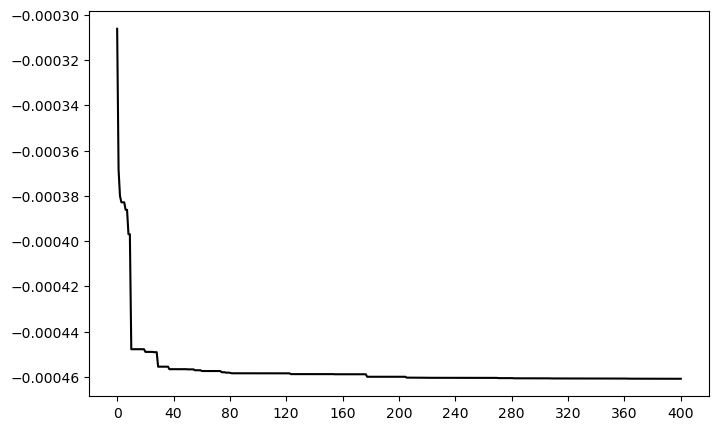

[I 2024-06-18 07:08:53,445] Trial 73 finished with value: -0.00046086848186876713 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


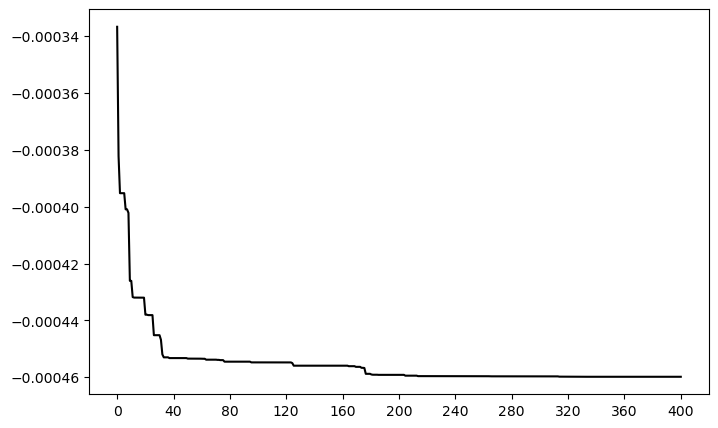

[I 2024-06-18 07:13:22,829] Trial 74 finished with value: -0.000459832042829882 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


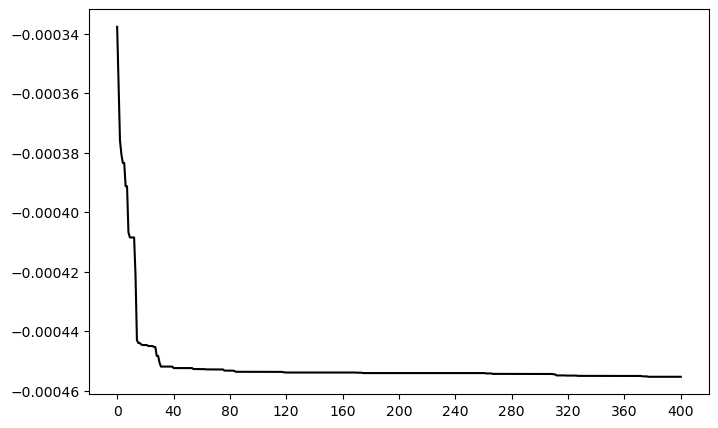

[I 2024-06-18 07:17:51,668] Trial 75 finished with value: -0.0004553752947234775 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


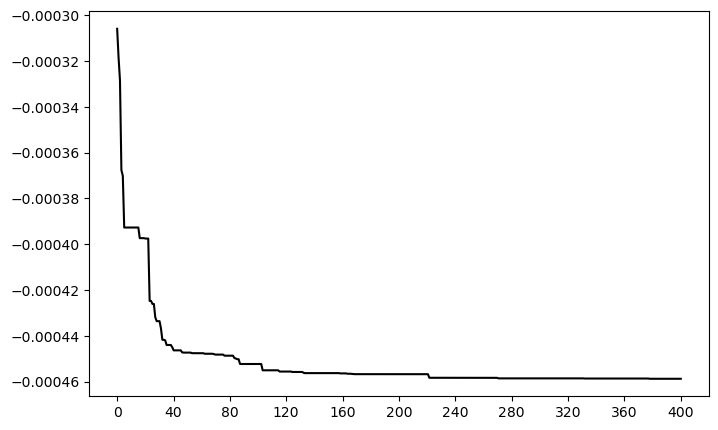

[I 2024-06-18 07:18:57,336] Trial 76 finished with value: -0.0004587872919497008 and parameters: {'population_size': 50, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


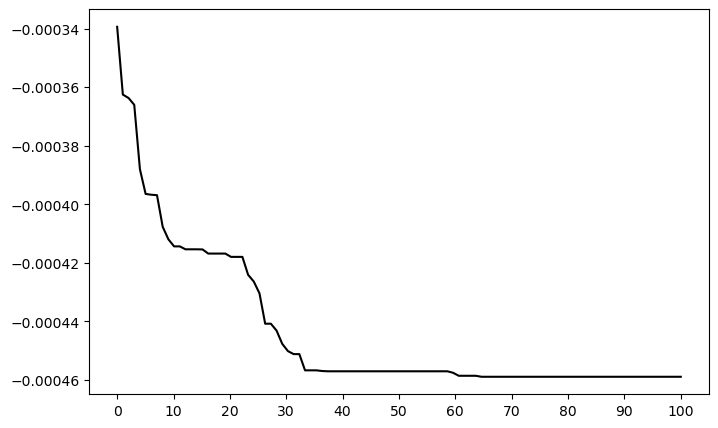

[I 2024-06-18 07:20:41,587] Trial 77 finished with value: -0.000458904225488522 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 100, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


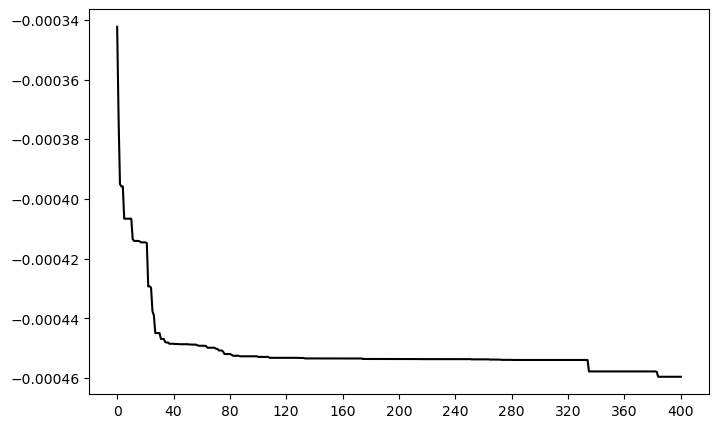

[I 2024-06-18 07:25:17,633] Trial 78 finished with value: -0.0004595104874322472 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 100
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


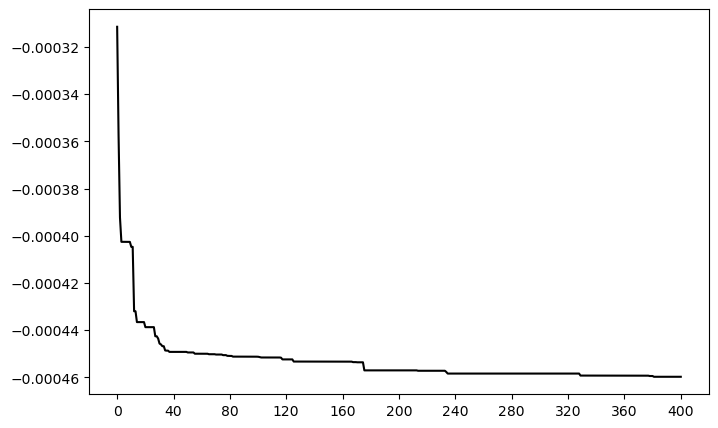

[I 2024-06-18 07:27:57,249] Trial 79 finished with value: -0.0004597793677748553 and parameters: {'population_size': 100, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


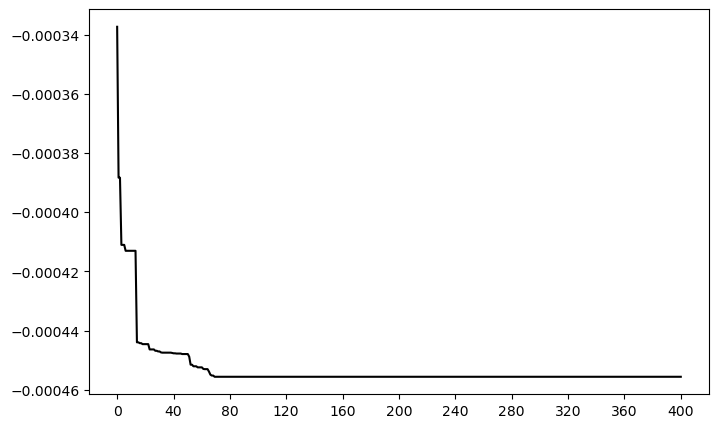

[I 2024-06-18 07:32:32,730] Trial 80 finished with value: -0.0004555982075195082 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 400, 'SPP': 100}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


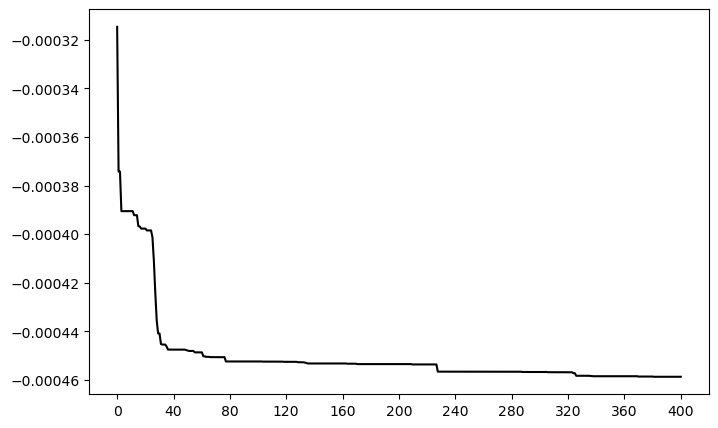

[I 2024-06-18 07:37:12,084] Trial 81 finished with value: -0.0004586927162304567 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


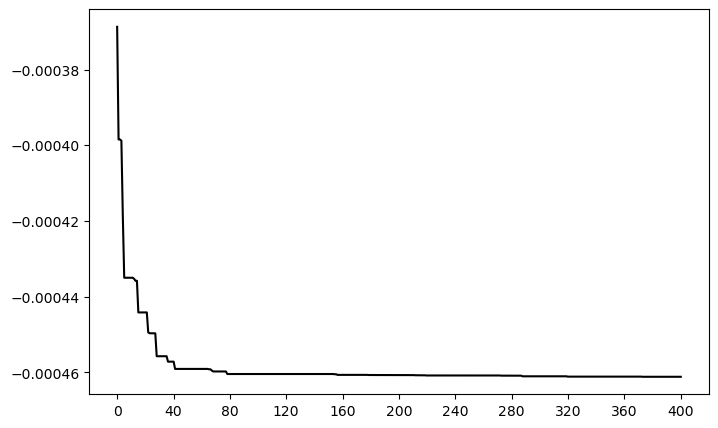

[I 2024-06-18 07:41:38,841] Trial 82 finished with value: -0.00046117943565631434 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


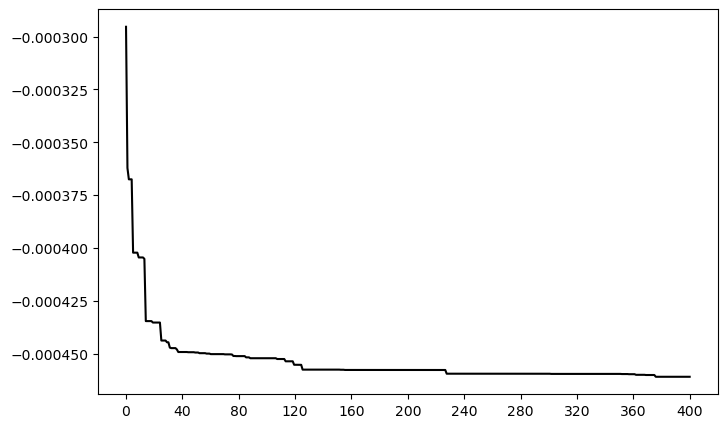

[I 2024-06-18 07:46:14,552] Trial 83 finished with value: -0.0004609324276184215 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 200
Risk Averse Parameter: 0.64


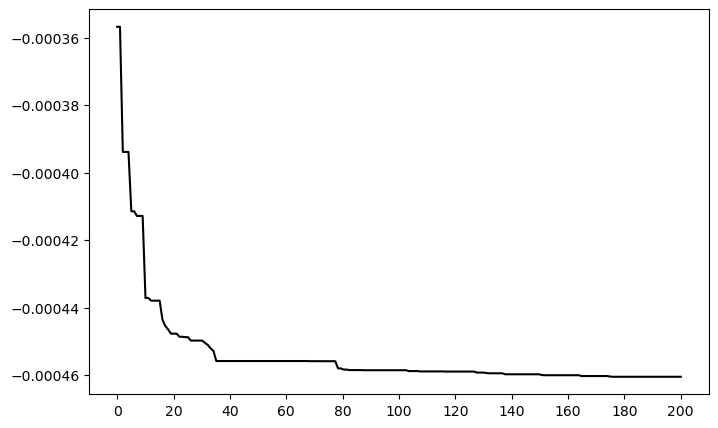

[I 2024-06-18 07:48:30,278] Trial 84 finished with value: -0.0004604731068072839 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 200, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


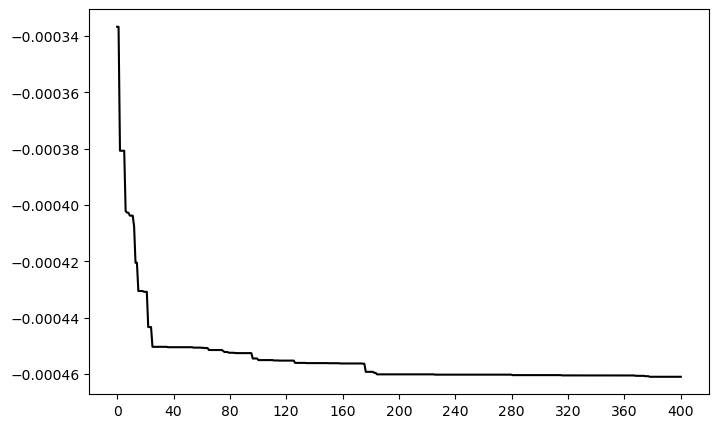

[I 2024-06-18 07:53:01,814] Trial 85 finished with value: -0.00046096235711810807 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


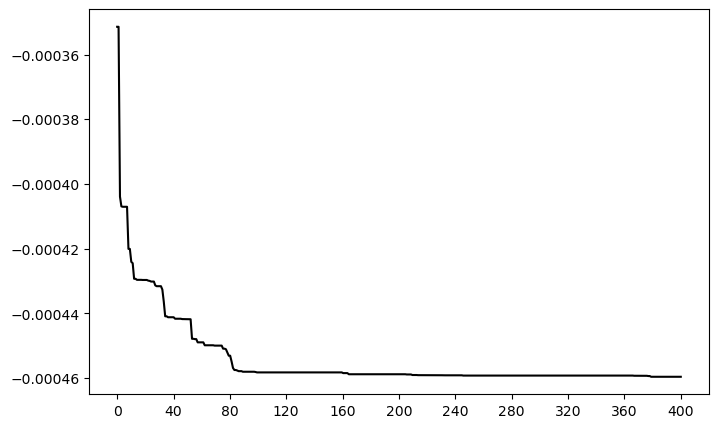

[I 2024-06-18 07:57:36,656] Trial 86 finished with value: -0.0004596278554229005 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 150}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


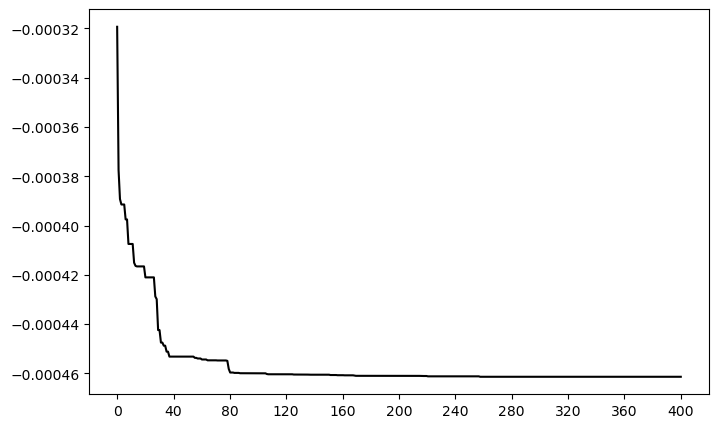

[I 2024-06-18 08:02:05,648] Trial 87 finished with value: -0.0004613614379164549 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


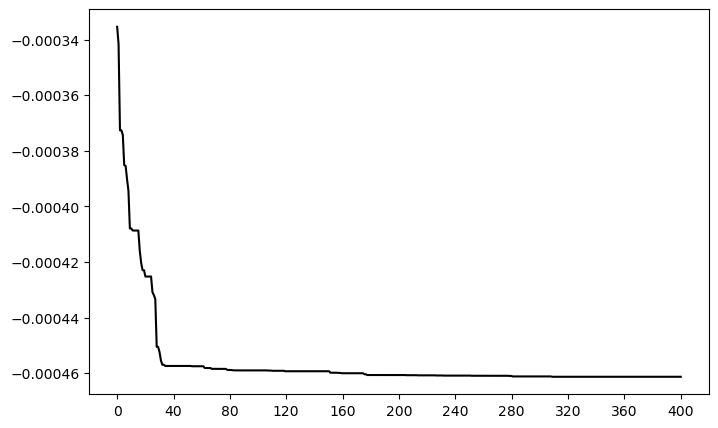

[I 2024-06-18 08:11:22,514] Trial 88 finished with value: -0.00046130848357119996 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 50
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


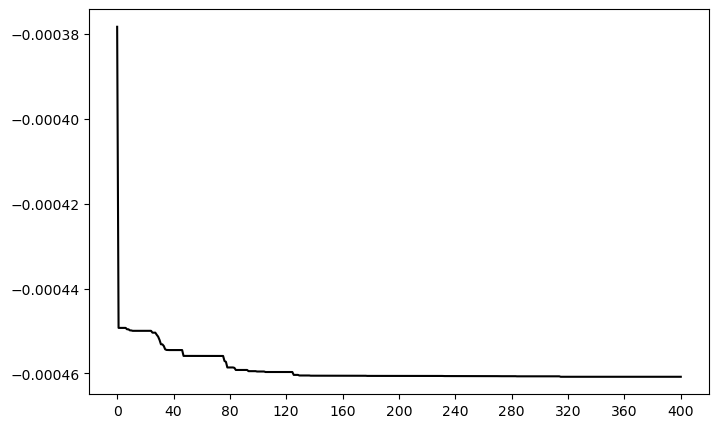

[I 2024-06-18 08:20:35,129] Trial 89 finished with value: -0.00046079016763923283 and parameters: {'population_size': 250, 'limit': 50, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


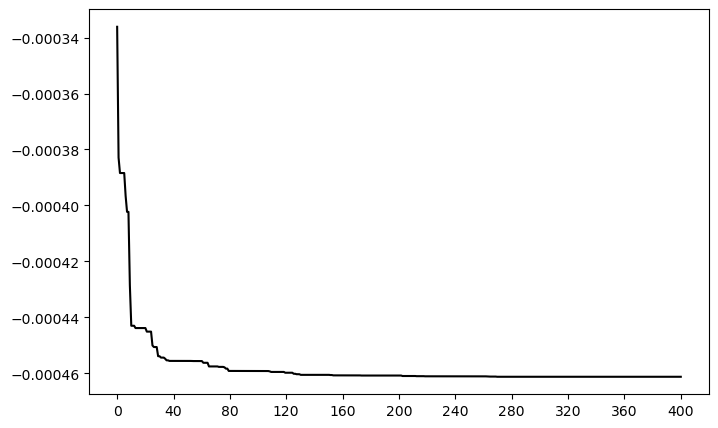

[I 2024-06-18 08:29:45,549] Trial 90 finished with value: -0.00046122447267291414 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


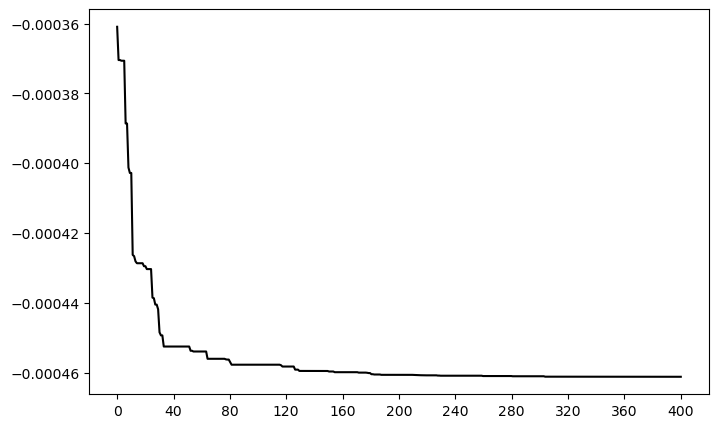

[I 2024-06-18 08:38:49,735] Trial 91 finished with value: -0.00046122060246928565 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


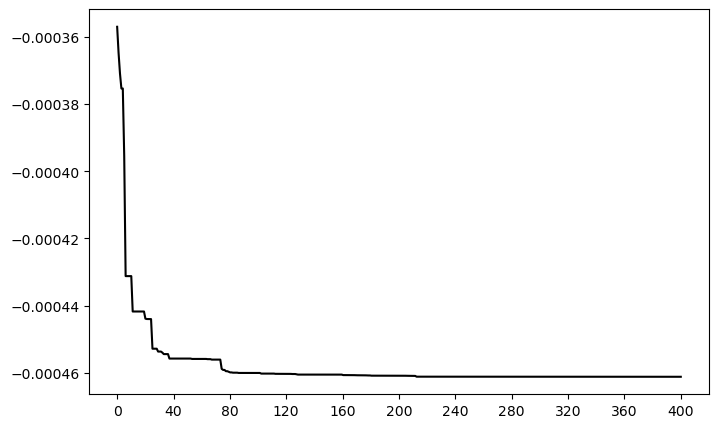

[I 2024-06-18 08:47:55,110] Trial 92 finished with value: -0.0004611694563510831 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 50
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


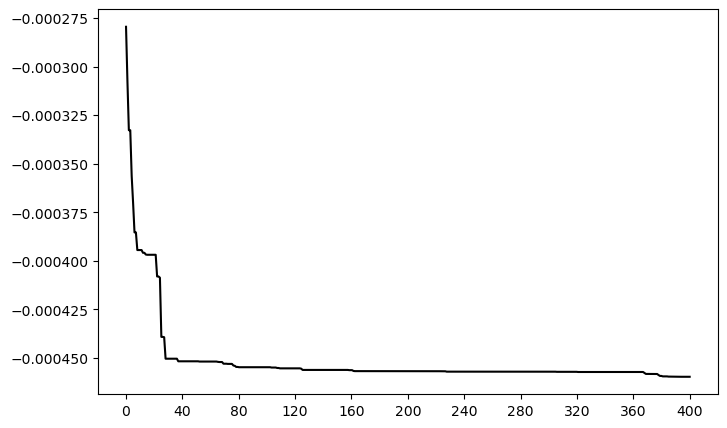

[I 2024-06-18 08:48:59,527] Trial 93 finished with value: -0.0004596312056791132 and parameters: {'population_size': 50, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


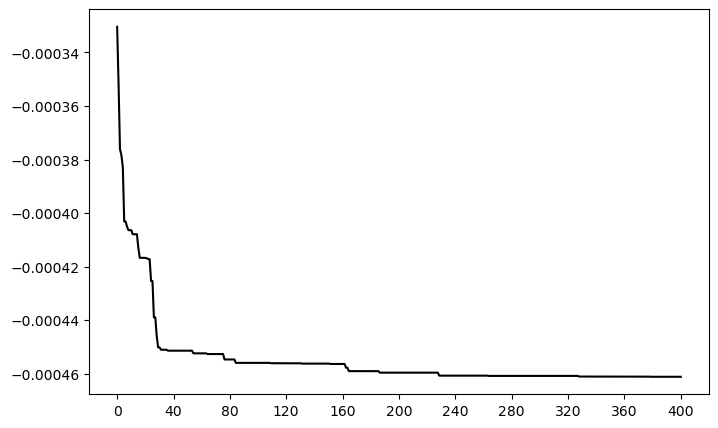

[I 2024-06-18 08:53:31,529] Trial 94 finished with value: -0.00046112649101931415 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 100
Risk Averse Parameter: 0.64


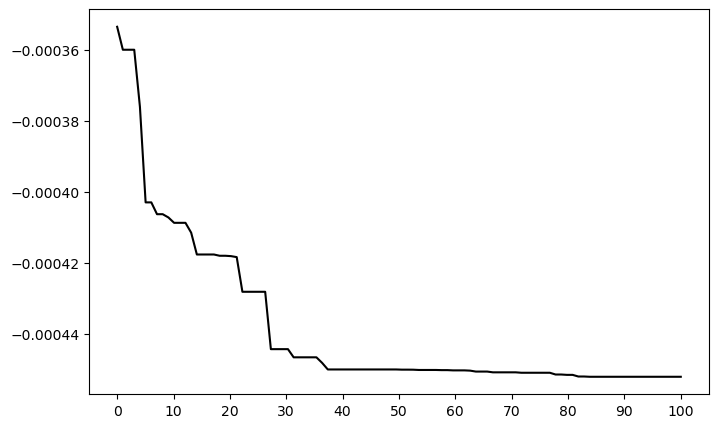

[I 2024-06-18 08:54:39,747] Trial 95 finished with value: -0.0004521071263494634 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 100, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 200
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


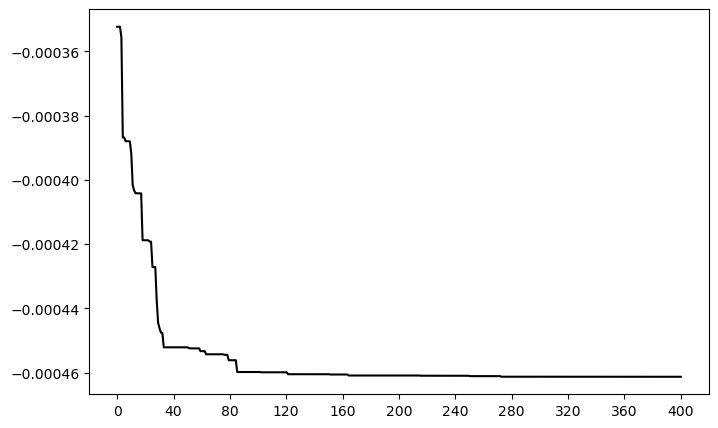

[I 2024-06-18 09:01:22,462] Trial 96 finished with value: -0.00046125548068057774 and parameters: {'population_size': 200, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 300
Risk Averse Parameter: 0.64


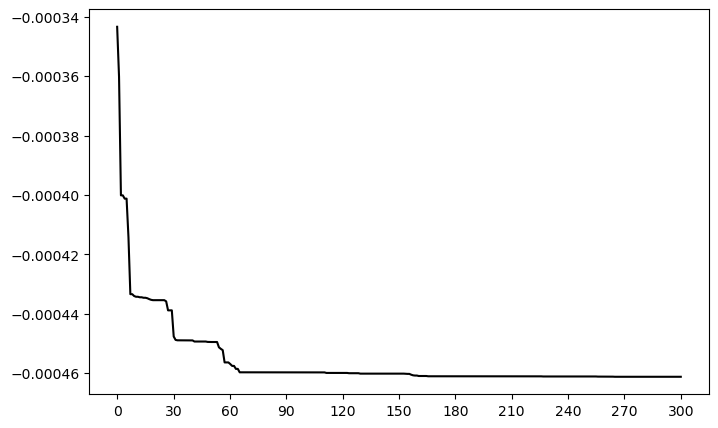

[I 2024-06-18 09:04:44,354] Trial 97 finished with value: -0.00046119239139952317 and parameters: {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 300, 'SPP': 100}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 250
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 100
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


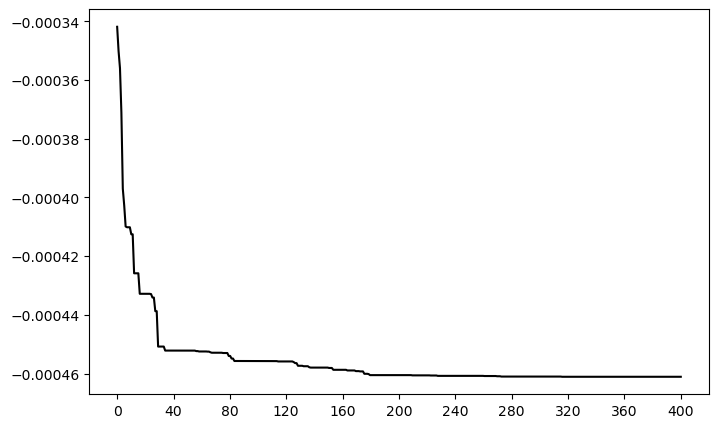

[I 2024-06-18 09:13:57,241] Trial 98 finished with value: -0.00046107530030026596 and parameters: {'population_size': 250, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


Parameter Information:
Population: 150
Dimension: 100
Bounds: [0.001, 0.4]
Cardinality: 15
Max Iter Num: 25
Algo Max Iter Num: 400
Risk Averse Parameter: 0.64


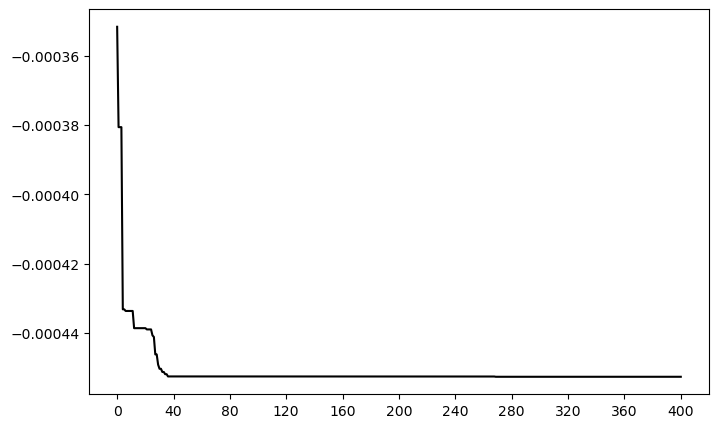

[I 2024-06-18 09:18:30,451] Trial 99 finished with value: -0.0004526484155316445 and parameters: {'population_size': 150, 'limit': 25, 'max_algo_iter_nums': 400, 'SPP': 50}. Best is trial 65 with value: -0.0004613828640520799.


最佳参数： {'population_size': 150, 'limit': 100, 'max_algo_iter_nums': 400, 'SPP': 50}
最佳适应度： -0.0004613828640520799


In [123]:
import optuna

def objective(trial):
    # 定义需要调优的参数
    global SP_cov_rtn,SP_mean_rtn
    
    my_population = trial.suggest_categorical('population_size', [50, 100, 150, 200, 250])
    
    my_parameter = ParameterInformation(
            my_population, 100, 0.001, 0.4, limit, max_algo_iter_nums, 0.64, 15, SPP)
    # 创建并运行 ABC 算法
    abc = artificial_bee_colony(my_parameter,SP_mean_rtn, SP_cov_rtn, 0.8)
    best_fitness = abc[0]

    # 返回适应度（或目标函数值）
    return best_fitness

# 创建 Optuna 的研究对象并开始调优
study = optuna.create_study(direction='minimize')  # 假设我们是要最小化目标函数
study.optimize(objective, n_trials=100)

print("最佳参数：", study.best_params)
print("最佳适应度：", study.best_value)